Notebook by **Sven Eis** - Final project for the course **Computational Statistics** in the summer term 2022 - University of Bonn
# Random Forest - Is the "out-of-the-box" performance optimal?
---
## Table of Contents
---
1. [Introduction](#introduction)
2. [Theory](#Theory)
    1. [Classification and Regression Trees](#CART)
    1. [Random Forests](#randomforest)
    1. [Variable Importance and Feature Selection](#VI_FS)
    1. [Recursive Feature Elimination](#RFE)
    1. [Tuning Strategies](#tuning)
3. [Preliminary Steps](#preliminaries)
4. [Simulation Studies](#simulation)
    1. [Simulation 1](#sim1)
    1. [Simulation 2](#sim2)
5. [Empirical Application](#application)
6. [Conclusion](#conclusion)
7. [References](#references)

---
## 1. Introduction <a name="introduction"></a>
---
Random Forest (RF) is a nonparametric statistical learning method introduced by *Ho (1995)* and extended by *Breiman (2001)*. The method can be applied to both classification and regression problems, thus allowing the consideration of qualitative and quantitative response variables. Due to their outstanding performance and ease of use, they are used in numerous application areas. Typical tasks where tree-based methods are used are variable selection or prediction, especially when predictor complexity is high. These cases are less common in economic contexts but are widely used in areas such as biostatistics. For an overview of the various application areas, see *Verikas, Gelzinis, and Bacauskiene (2011)*. <br>

Since they are widely used, it is of interest how and under which circumstances the best performance can be achieved. This project, therefore, addresses this very question. The RF algorithm has a reputation for achieving very good performance "out-of-the-box", i.e. without the so-called tuning (*Boehmke, and Greenwell, 2019*). However, the question arises whether this is always the case. Are there situations in which the "out-of-the-box" RF performs comparatively poorly? In such cases, can hyperparameter tuning be helpful or are there other possibilities that can lead to improved performance? This project attempts to address these questions with the help of various simulation studies and an empirical application. <br>

In this project, I first discuss the theoretical background of the method in Chapter 2, taking a closer look at the Classification and Regression Trees (CART) algorithm and then at the RF method, which is based on CART. In the next step, I will then explain various techniques that can be used to improve performance. After introducing the general concept of variable importance and feature selection, I discuss those methods that will play a role in the later part of the project. Here I focus on Recursive Feature Elimination (RFE) and tuning the hyperparamete *$m_{try}$* . After describing the theoretical assumptions in more detail, I show two simulation studies that generally address the question if the "out-of-the-box" RF performs is optimal or whether a "out-of-the-box" RF with prior RFE or *$m_{try}$* -tuning performs relatively better. To this end, I present a data generation process (DGP) that differs slightly depending on the research question. After the simulation studies, I transfer these methods to a real-world application using a dataset of German credit data. Finally, I summarize my results and give an outlook on further possible extensions of the presented framework. <br> 

---
## 2. Theory <a name="theory"></a>
---
In the following section, I present some theoretical assumptions that serve to understand and interpret the simulation and the empirical application. Since the focus of the simulations and the empirical application is on the optimal performance of RF applications, I will first explain, in a historically motivated manner, the various methods that built upon each other from time to time and finally resulted in the RF algorithm.<br> 

---
### A. Classification and Regression Trees <a name="CART"></a>
---
This project deals with a so-called tree-based method. Thereby one can analyze two types of decision problems:
1. Classification Trees: The target variable (independent variable) is discrete, i.e. it has a finite set of nominal values
2. Regression trees: The target variable is continuous

The method discussed in this project, like many other decision tree algorithms, has its origins in the **CART** algorithm, which is used for decision-making. This algorithm was first published by *Breiman et al. (1984)*.
In the following, I would present the algorithm, although my description will focus only on the classification case of CART since this is the focus of this project. In describing the algorithm, I closely follow *Kuzilek et al. (2014)*.[<sup>1</sup>](#fn1) They describe the classification algorithm for creating a decision tree as follows: *(quoting from the paper)* <br> 

> 1. <em> Find each feature’s best split. For each feature with K different values there exist K-1 possible splits. Find the split, which maximizes the splitting criterion. The resulting set of splits contains best splits (one for each feature). </em>
> 2. <em> Find the node’s best split. Among the best splits from Step 1 find the one, which maximizes the splitting criterion. </em>
> 3. <em> Split the node using best node split from Step 2 and repeat from Step 1 until stopping criterion is satisfied. </em>

Various methods can be used as as splitting criterion. The typical choice in a regression setup, the sum of squared residuals (RSS), cannot be used in a classification setup because we want to "*assign an observation in a given region to the most commonly occuring class of training observations in that region*" (James et al., 2021, p. 335).<br> 

As an alternative to the RSS, the so-called *classification error rate* is used:
\begin{equation}
E=1-\underset{k}{max}(\hat{p}_{mk})
\end{equation}
where $\hat{p}_{mk} \in [0,1]$ is the proportion of training observations in the $m$th region that are from the $k$th class.

Since the classification error is not very sensitive for tree-growing, two other methods are more widely used:
- *Gini Index*, a measure of total variance across all K classes:  \begin{equation} G=\sum_{k=1}^{K}\hat{p}_{mk}(1-\hat{p}_{mk}) \end{equation}
- *Entropy*: \begin{equation} D=-\sum_{k=1}^{K}\hat{p}_{mk}log\hat{p}_{mk} \end{equation}

In the further course of this project, especially for the simulations and the empirical application, the *Gini Index* is used as a splitting criterion. It should be noted, that this splitting criterion favors the selection of predictors with many possible splits (e.g., continuous variables or categorical variables with many categories) over variables with fewer splits (e.g., binary variables, which have only one possible split) (*Strobl et al., 2007*). Since in the simulation studies (Chapter 4), the predictors are all continuous, this issue should not occur here. However, in the empirical application (Chapter 5), predictors are used that have different amounts of categories.<br> 

---
### B. Random Forest <a name="randomforest"></a>
---
Building on the CART algorithm, which is a fairly simple method for building classification and regression trees, there are several ways to improve not only prediction performance but also other properties by combining multiple trees. One of them is Random Forest, which is itself a variation of Bagged Decision Trees that form a large collection of decorrelated trees to further improve the prediction performance (*Boehmke, and Greenwell, 2019*). This method was introduced by *Ho (1995)* and extended by *Breiman (2001)*. The RF provides good predictive performance with relatively little adjustment to the hyperparameters and has therefore become a very popular "out-of-the-box" algorithm.<br> 

###### Extending Bagging
Bagging, i.e. Bootstrap aggregating, is one of the first ensemble methods and is based on the CART algorithm. It fits multiple models to different subsets of a training dataset and then aggregates the predictions from all models. Therefore, not only the variance but also the predictive performance is improved (*Boehmke, and Greenwell, 2019*). However, bagging trees results in tree correlation, whereby the effect of variance reduction is limited. To address this problem, the RF method was introduced.

The RF is an extension of bagging and helps to reduce tree correlation. The decorrelation process is primarily driven by injecting more randomness into the growing process of the tree. The RF algorithm randomly chooses $m≈\sqrt{p}$ covariates (classification tree), where p is the number of covariates, that are considered for the new split. A new sample of m predictors is taken at each split. In bagging, m is always equal to the number of covariates p.

In the following, I would present the algorithm for a classification RF. For the description of the algorithm I am following closely *Boehmke, and Greenwell (2019)* [<sup>2</sup>](#fn2) They describe the basic classification random forest algorithm as follows: (*quoting from the book*)

> 1. <em> Given a training data set </em>
> 1. <em> Select number of trees to build (n_trees) </em>
> 1. <em> for i = 1 to n_trees do </em>
> 1. <em> <div style="text-indent:10px;">Generate a bootstrap sample of the original data</div> </em>
> 1. <em> <div style="text-indent:10px;">Grow a regression/classification tree to the bootstrapped data</div> </em>
> 1. <em> <div style="text-indent:10px;">for each split do</div> </em>
> 1. <em> <div style="text-indent:30px;">Select m_try variables at random from all p variables</div> </em>
> 1. <em> <div style="text-indent:30px;">Pick the best variable/split-point among the m_try</div> </em>
> 1. <em> <div style="text-indent:30px;">Split the node into two child nodes</div> </em>
> 1. <em> <div style="text-indent:10px;">end</div> </em>
> 1. <em> <div style="text-indent:10px;">Use typical tree model stopping criteria to determine when a tree is complete (but do not prune)</div> </em>
> 1. <em> end </em> <br>
> 1. <em> Output ensemble of trees </em>

###### Irrelevant Features
The RF algorithm does not distinguish between the relevance of features when building the forest. Since the features are randomly selected at each node with equal probability, the presence of irrelevant features can significantly decrease performance. As RF lacks to select the optimal feature, the probability of selecting an irrelevant feature increases with the proportion of irrelevant features present and thus increases the generalization error (*Rogers, and Gunn, 2005*).

As *Rogers, and Gunn (2005)* have described, irrelevant features have a large impact on the performance of the RF algorithm, so a closer look at this phenomenon is of interest (see Chapter 4, Simulation 1). One way to address this problem is discussed in the following section. 

---
### C. Variable Importance and Feature Selection <a name="VI_FS"></a>
---
###### Variable Importance
In general, one can distinguish between two types of functions that evaluate variable importance: those that use the model information and those that do not. Regardless of how the importance is calculated each predictor will have separate variable importance for each class (exceptions are classification trees, bagged trees, and boosted trees) (*Kuhn, 2019*). 

Regarding the variable importance of the RF algorithm, the following is written in the documentation from the R package:[<sup>3</sup>](#fn3)
"*For each tree, the prediction accuracy on the out-of-bag portion of the data is recorded. Then the same is done after permuting each predictor variable. The difference between the two accuracies are then averaged over all trees, and normalized by the standard error. For regression, the MSE is computed on the out-of-bag data for each tree, and then the same computed after permuting a variable. The differences are averaged and normalized by the standard error. If the standard error is equal to 0 for a variable, the division is not done*."

###### Feature Selection
Many models do not necessarily use all predictors and have built-in feature selection, while the RF model is not one of them. In many cases, models with built-in feature selection are more efficient than those where the search algorithm for the relevant predictors is external. Since the RF model does not have built-in feature selection, one must use external algorithms. These external algorithms can be divided into two main categories following the terminology of *John, Kohavi, and Pfleger (1994)*:

1. Filter methods: Evaluate the relevance of the predictors and model only those predictors that meet a given criterion. For an overview of different filter methods, see *Saeys, Inza, and Larranaga (2007)*.
2. Wrapper methods: Procedures that add/remove predictors to maximize model performance. These include, among others, Recursive Feature Elimination, Genetic Algorithms, and Simulated Annealing.

A disadvantage of the filter method is that it evaluates each predictor separately and therefore highly correlated predictors with important interactions may not be selected (*Kuhn, 2019*). A disadvantage of the wrapper method is that many models are evaluated, which increases computation time. To circumvent the disadvantage of the filter method, which may occur especially in Simulation 2 (Chapter 4, Section B.), I will use a wrapper method and in particular, Recursive Feature Elimination (RFE), described below and applied in the simulation studies as well as in the empirical application.

---
### D. Recursive Feature Elimination <a name="RFE"></a>
---
In general, one can find two different types of algorithms that perform RFE. Both are implemented in the R package *caret*, which is used for the following simulations as well as for the empirical application. The function *rfeIter* performs a backward selection and the function *rfe* performs a backward selection with an additional resampling-based algorithm.

The *rfeIter*-algorithm fits the model to all predictors and ranks each of them according to their importance. At each iteration, the best-ranked predictors are retained, the model is refitted, performance is evaluated, and the top predictors are used to fit the final model. However, there is a potential problem. Suppose there is a non-informative predictor that happens to be correlated with the outcome. The RFE algorithm would assign a good rank to this said variable and the prediction error would decrease. This problem is referred to by *Ambroise and McLachlan (2002)* as "*selection bias*".

Given the potential selection bias issue, this project focuses only on *rfe*, even though it is more computationally expensive. To obtain performance estimates that incorporate variation due to feature selection, it is proposed to encapsulate the steps of the *rfeIter* algorithm in an outer layer of resampling, resulting in the *rfe* -algorithm. In the following, I will present the algorithm of the *rfe* -function. In describing the algorithm, I closely follow *Kuhn (2019)*. He describes the RFE algorithm as follows: (*quoting from the website*)

> 1. <em> for Each Resampling Iteration do </em>
> 1. <em> <div style="text-indent:10px;">Partition data into training and test/hold-back set via resampling</div> </em>
> 1. <em> <div style="text-indent:10px;">Tune/train the model on the training set using all predictors</div> </em>
> 1. <em> <div style="text-indent:10px;">Predict the held-back samples</div> </em>
> 1. <em> <div style="text-indent:10px;">Calculate variable importance or rankings</div> </em>
> 1. <em> <div style="text-indent:10px;">for Each subst size $S_{i}, i=1,...,S$ do</div> </em>
> 1. <em> <div style="text-indent:30px;">Keep the $S_{i}$ most important variables</div> </em>
> 1. <em> <div style="text-indent:30px;">[Optional] Pre-process the data</div> </em>
> 1. <em> <div style="text-indent:30px;">Tune/train the model on the training set using $S_{i}$ predictors</div> </em>
> 1. <em> <div style="text-indent:30px;">Tune/train the model on the training set using $S_{i}$ predictors</div> </em>
> 1. <em> <div style="text-indent:30px;">Predict the held-back samples</div> </em>
> 1. <em> <div style="text-indent:30px;">[Optional] Recalculate the rankings for each predictor</div> </em>
> 1. <em> <div style="text-indent:10px;">end</div> </em>
> 1. <em> end </em>
> 1. <em> Calculate the performance profile over the $S_{i}$ using the held-back samples </em>
> 1. <em> Determine the appropiate number of predictors to keep in the final model </em>
> 1. <em> Fit the final model based on the optimal $S_{i}$ using the original training set </em>

---
### F. Tuning Strategies <a name="tuning"></a>
---
The following section discusses different strategies for tuning hyperparameters in RF and how they can help optimize performance. A detailed overview can be found in *Probst et al. (2019)*, where various strategies for tuning RF are discussed. These include the structure of each tree (minimal node size), the randomness of the forest (number considered at each split *$m_{try}$* ), and the size of the forest (number of trees). The following table gives an overview of the hyperparameters:

**Table 1** Overview of the different hyperparameters of RF and typical default values, n is the number of observations and p is the number of variables in the dataset

| Hyperparameter  | Description                                        | Typical default values                   |
| :-------------- | :------------------------------------------------- | :--------------------------------------- |
| *$m_{try}$*          | Number of drawn candidate variables in each split  | $\sqrt{p}$ for classification, $p/3$ for regression |
| Sample size     | Number of observations that are drawn for each tree | n                                        |
| Replacement     | Draw observations with or without replacement      | TRUE (with replacement)                  |
| Node size       | Minimum number of observations in a terminal node  | 1 for classification, 5 for regression   |
| Number of trees | Number of trees in the forest                      | 500, 1000                                |
| Splitting rule  | Splitting criteria in the nodes                    | Gini impurity, p value, random           |

Source: *Probst et al. (2019), p. 4*.

In this project, I focus on one of the key hyperparameters in a RF, the number of randomly drawn candidate variables in each split, often abbreviated as *$m_{try}$*.

###### The $m_{try}$ -hyperparameter
As described previously, the hyperparameter *$m_{try}$* describes the number of candidate variables drawn in each split. Lower values of *$m_{try}$* result in a more stable forest, as there are more distinct, less correlated trees. There is a tradeoff, however, in that lower values of *$m_{try}$* also lead to trees that perform worse on average because irrelevant variables may be selected.

As a typical default value, *$m_{try}$* is set to $\sqrt{p}$ for classification and $p/3$ for regression, where $p$ is the number of predictors. *Bernard et al. (2009)* conclude that $m_{try}=\sqrt{p}$ is a reasonable value, but it can sometimes be improved. *$m_{try}$* should be chosen small if there are many relevant predictors, which can lead to small but relevant performance gains (*Probst et al., 2019*). On the other hand, if there are only a few relevant variables among many, *$m_{try}$* should be set high to allow the algorithm to find the relevant variables (*Goldstein et al., 2011*).

<span id="fn1"> <sup>[1]</sup>: See Appendix S2 "CART algorithm and pruning." of their paper
(https://doi.org/10.1371/journal.pone.0098450.s002). </span> <br>
<span id="fn2"> <sup>[2]</sup>: See Chapter 11.2 "Extending Bagging", p. 204 of their book. </span>
<span id="fn3"> <sup>[3]</sup>: See https://cran.r-project.org/web/packages/randomForest/randomForest.pdf, p. 6. </span>

---
## 3. Preliminary Steps <a name="preliminaries"></a>
---
Install the following packages if necessary:

In [ ]:
#install.packages("randomForest")
#install.packages("caret")
#install.packages("ggplot2")
#install.packages("gridExtra")
#install.packages("MASS")
#install.packages("reshape2")  
#install.packages("sampling")

Load the packages:

In [6]:
suppressMessages(library(randomForest))
suppressMessages(library(caret))
suppressMessages(library(ggplot2))
suppressMessages(library(gridExtra))
suppressMessages(library(MASS))
suppressMessages(library(reshape2)) 
suppressMessages(library(sampling)) 

options(repr.plot.width=30, repr.plot.height=10) # adjust plot size

For details on the functions which have been used in both simulations and empirical application consult the file *Simulation/sim_functions.R* and *Application/appl_functions.R*:

In [11]:
source("Simulation/sim_functions.R")
source("Application/appl_functions.R")

---
## 4. Simulation Studies  <a name="simulation"></a>
---
For the simulation study, I want to introduce a data generating process (DGP), which is based on *Hapfelmeier et al. (2014)*:

- (Binary) Response variable Y is modeled by means of a logistic model:

\begin{equation}
P(Y=1|X=x)=\frac{e^{X^{T}\beta}}{1+e^{X^{T}\beta}}
\end{equation}

- Predictors X are drawn from a p-dimensional normal distribution: $N(0,\Sigma)$, with $p=20$, and $\Sigma = \begin{bmatrix}
            1.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & \cdots & 0.0\\
            0.0 & 1.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & \cdots & 0.0\\
            0.0 & 0.0 & 1.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & \cdots & 0.0\\
            0.0 & 0.0 & 0.0 & 1.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & \cdots & 0.0\\
            0.0 & 0.0 & 0.0 & 0.0 & 1.0 & 0.0 & 0.0 & 0.0 & 0.0 & \cdots & 0.0\\
            0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.0 & 0.0 & 0.0 & 0.0 & \cdots & 0.0\\
            0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.0 & 0.0 & 0.0 & \cdots & 0.0\\
            0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.0 & 0.0 & \cdots & 0.0\\
            0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.0 & \cdots & 0.0\\
            0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.0 & ... & 0.0\\
            \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & 0.0\\
            0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & \cdots & 1.0\\
        \end{bmatrix}$
- $\beta = (4,4,3,4,3,4,3,4,3,0,0,2,2,0,0,0,0,0,0,0)^T$
- 100 observations

For all upcoming simulations, I will use this GDP or a slight variation of it. In general, my goal is to simulate whether the "out-of-the-box" RF outperforms a *$m_{try}$* -tuned RF and how the "out-of-the-box" RF with prior RFE compares to the other two.
To evaluate this, I will run two simulations where I will adjust the basic setup:
- Simulation 1: Basic GDP as described above with an additional increasing amount of irrelevant predictors
- Simulation 2: Baseline GDP with an adjusted variance-covariance matrix $\Sigma$ and thus varying randomized predictors

The run times of each simulation are shown below:

|              | Simulation 1 | Simulation 2 |
| :----------- | :----------- | :----------- |
| Running time | 5.5 h        | 5.75 h       |

---
### A. Simulation 1  <a name="sim1"></a>
---
For the first simulation, I would like to address a potential problem that was already mentioned in the theory chapter. As described above, the RF algorithm does not distinguish between the relevance of features when building the forest. These irrelevant features can therefore mislead the algorithm and increase the error (*Rogers, and Gunn, 2005*). 

To simulate this problem, I will increase the number of irrelevant features in several steps and see how the "out-of-the-box" RF ($m_{try}=\sqrt{p}$) handles this problem compared to a *$m_{try}$* -tuned RF and a "out-of-the-box" RF with prior RFE. I will run a simulation with 200 iterations on these different RFs with the DGP described above and no irrelevant features ($p=20$), with 100 irrelevant and 20 relevant features ($p=120$), and with 500 irrelevant and 20 relevant features ($p=520$).

RF has a reputation for performing very well without tuning. However, I suspect that this performance decreases relative to the others as the number of irrelevant predictors increases. As *Goldstein et al. (2011)* stated, *$m_{try}$* should be set high when there are only a few relevant variables among many so that the algorithm can find the relevant variables. Thus, the *$m_{try}$* -tuned RF should have a better test error than the "out-of-the-box" RF, especially for the cases with $p=120$ and $p=520$. In particular, I suspect that the RF with prior RFE will perform comparatively gradually better as the number of irrelevant features increases since these should be detected and removed by the algorithm.

The output of the functions used in this simulation and the test errors are stored in subdirectories of *Simulation/Data/Simulation_1*.

In [103]:
source("Simulation/container_sim1.R")

control <- rfeControl(functions = rfFuncs, # random forest
                      method = "repeatedcv", # repeated cv
                      repeats = 5, # number of repeats
                      number = 10) # number of folds

iter <- 200
p <- 20
n <- 100
mu_vec<-rep(0,p)
SIGMA <- diag(1, ncol = p, nrow = p)
beta <- c(4, 4, 3, 4, 3, 4, 3, 4, 3, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0)

ptm<-proc.time()

for (i in 1:iter){
  set.seed (i)
  MyData<-DataGenerator(p, n, mu_vec, SIGMA, beta)
  MyData.N100<-AddFakePredictors(MyData, 100)
  MyData.N500<-AddFakePredictors(MyData, 500)
  
  #Make train sample
  train <- sample(1:nrow(MyData), n/2)
  train.N100 <- sample(1:nrow(MyData.N100), n/2)
  train.N500 <- sample(1:nrow(MyData.N500), n/2)
  
  MyData.test <- MyData[-train,]
  MyData.train <- MyData[train,]
  MyData.test.N100 <- MyData.N100[-train.N100,]
  MyData.test.N500 <- MyData.N500[-train.N500,]
  MyData.train.N100 <- MyData.N100[train.N100,]
  MyData.train.N500 <- MyData.N500[train.N500,]
  Y.test<- MyData$Y[-train]
  Y.test.N100<- MyData.N100$Y[-train.N100]
  Y.test.N500<- MyData.N500$Y[-train.N500]
  
  #Random Forest - default
  randomForest_default <- randomForestDefault(data=MyData,subset=train)
  saveRDS(object = randomForest_default, file = paste0("Simulation/Data/Simulation_1/randomForest_default/RF_def_it", i, ".RDS"))
  
  #Random Forest - default - Test Error
  test.error.rf.def.sim[i]<- 1 - (table(randomForest_default, Y.test)[1,1] + table(randomForest_default, Y.test)[2,2] ) /(n/2)
  saveRDS(object = test.error.rf.def.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_default/Test_Errors/RF_def_it", i, ".RDS"))
  average.rf.def.sim[i]<-mean(test.error.rf.def.sim)
  saveRDS(object = average.rf.def.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_default/Test_Errors/Averages/RF_def_it", i, ".RDS"))

  #Random Forest - default - N100
  randomForest_default.N100 <- randomForestDefault(data=MyData.N100,subset=train.N100)
  saveRDS(object = randomForest_default.N100, file = paste0("Simulation/Data/Simulation_1/randomForest_default/RF_def_N100_it", i, ".RDS"))
  
  #Random Forest - default - N100 - Test Error
  test.error.rf.def.N100.sim[i] <- 1 - (table(randomForest_default.N100, Y.test.N100)[1,1] + table(randomForest_default.N100, Y.test.N100)[2,2] ) /(n/2)
  saveRDS(object = test.error.rf.def.N100.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_default/Test_Errors/RF_def_N100_it", i, ".RDS"))
  average.rf.def.N100.sim[i]<-mean(test.error.rf.def.N100.sim)
  saveRDS(object = average.rf.def.N100.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_default/Test_Errors/Averages/RF_def_N100_it", i, ".RDS"))
  
  #Random Forest - default - N500
  randomForest_default.N500 <- randomForestDefault(data=MyData.N500,subset=train.N500)
  saveRDS(object = randomForest_default.N500, file = paste0("Simulation/Data/Simulation_1/randomForest_default/RF_def_N500_it", i, ".RDS"))
  
  #Random Forest - default - N500 - Test Error
  test.error.rf.def.N500.sim[i] <- 1 - (table(randomForest_default.N500, Y.test.N500)[1,1] + table(randomForest_default.N500, Y.test.N500)[2,2] ) /(n/2)
  saveRDS(object = test.error.rf.def.N500.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_default/Test_Errors/RF_def_N500_it", i, ".RDS"))
  average.rf.def.N500.sim[i]<-mean(test.error.rf.def.N500.sim)
  saveRDS(object = average.rf.def.N500.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_default/Test_Errors/Averages/RF_def_N500_it", i, ".RDS"))
  
  #Random Forest - optimal
  randomForest_tuned <- randomForestTuned(data=MyData,subset=train,Y.test=Y.test)
  saveRDS(object = randomForest_tuned, file = paste0("Simulation/Data/Simulation_1/randomForest_tuned/RF_tuned_it", i, ".RDS"))
  
  #Random Forest - optimal - Test Error
  test.error.rf.opt.sim[i] <- 1 - (table(randomForest_tuned, Y.test)[1,1] + table(randomForest_tuned, Y.test)[2,2] ) /(n/2)
  saveRDS(object = test.error.rf.opt.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_tuned/Test_Errors/RF_tuned_it", i, ".RDS"))
  average.rf.opt.sim[i]<-mean(test.error.rf.opt.sim)
  saveRDS(object = average.rf.opt.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_tuned/Test_Errors/Averages/RF_tuned_it", i, ".RDS"))
  
  #Random Forest - optimal - N100
  randomForest_tuned.N100 <- randomForestTuned(data=MyData.N100,subset=train.N100,Y.test=Y.test)
  saveRDS(object = randomForest_tuned.N100, file = paste0("Simulation/Data/Simulation_1/randomForest_tuned/RF_tuned_N100_it", i, ".RDS"))
  
  #Random Forest - optimal - Test Error
  test.error.rf.opt.N100.sim[i] <- 1 - (table(randomForest_tuned.N100, Y.test.N100)[1,1] + table(randomForest_tuned.N100, Y.test.N100)[2,2] ) /(n/2)
  saveRDS(object = test.error.rf.opt.N100.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_tuned/Test_Errors/RF_tuned_N100_it", i, ".RDS"))
  average.rf.opt.N100.sim[i]<-mean(test.error.rf.opt.N100.sim)
  saveRDS(object = average.rf.opt.N100.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_tuned/Test_Errors/Averages/RF_tuned_N100_it", i, ".RDS"))
  
  #Random Forest - optimal - N500
  randomForest_tuned.N500 <- randomForestTuned(data=MyData.N500,subset=train.N500,Y.test=Y.test)
  saveRDS(object = randomForest_tuned.N500, file = paste0("Simulation/Data/Simulation_1/randomForest_tuned/RF_tuned_N500_it", i, ".RDS"))
  
  #Random Forest - optimal - Test Error
  test.error.rf.opt.N500.sim[i] <- 1 - (table(randomForest_tuned.N500, Y.test.N500)[1,1] + table(randomForest_tuned.N500, Y.test.N500)[2,2] ) /(n/2)
  saveRDS(object = test.error.rf.opt.N500.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_tuned/Test_Errors/RF_tuned_N500_it", i, ".RDS"))
  average.rf.opt.N500.sim[i]<-mean(test.error.rf.opt.N500.sim)
  saveRDS(object = average.rf.opt.N500.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_tuned/Test_Errors/Averages/RF_tuned_N500_it", i, ".RDS"))
  
  #Recursive Feature Elimination
  RFE <- RFEAlgo(data=MyData,data.train=MyData.train)
  saveRDS(object = RFE, file = paste0("Simulation/Data/Simulation_1/rfe/rfe_it", i, ".RDS"))
  
  length.X[i]<-NCOL(RFE[,-1])
  #Random Forest - default - RFE
  randomForest_rfe <- randomForestDefault(data=RFE,subset=train)
  saveRDS(object = randomForest_rfe, file = paste0("Simulation/Data/Simulation_1/randomForest_rfe/RF_rfe_it", i, ".RDS"))
  
  #Random Forest - default - RFE - Test Error
  test.error.rf.rfe.def.sim[i] <- 1 - (table(randomForest_rfe, Y.test)[1,1] + table(randomForest_rfe, Y.test)[2,2] ) /(n/2)
  saveRDS(object = test.error.rf.rfe.def.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_rfe/Test_Errors/RF_rfe_it", i, ".RDS"))
  average.rf.rfe.def.sim[i]<-mean(test.error.rf.rfe.def.sim)
  saveRDS(object = average.rf.rfe.def.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_rfe/Test_Errors/Averages/RF_rfe_it", i, ".RDS"))
  
  #Recursive Feature Elimination - N100
  RFE.N100 <- RFEAlgo(data=MyData.N100,data.train=MyData.train.N100)
  saveRDS(object = RFE.N100, file = paste0("Simulation/Data/Simulation_1/rfe/rfe_N100_it", i, ".RDS"))
  
  length.X.N100[i]<-NCOL(RFE.N100[,-1])
  
  #Random Forest - default - RFE - N100
  randomForest_rfe.N100 <- randomForestDefault(data=RFE.N100,subset=train.N100)
  saveRDS(object = randomForest_rfe.N100, file = paste0("Simulation/Data/Simulation_1/randomForest_rfe/RF_rfe_N100_it", i, ".RDS"))
  
  #Random Forest - default - RFE - N100 - Test Error
  test.error.rf.rfe.def.N100.sim[i] <- 1 - (table(randomForest_rfe.N100, Y.test.N100)[1,1] + table(randomForest_rfe.N100, Y.test.N100)[2,2] ) /(n/2)
  saveRDS(object = test.error.rf.rfe.def.N100.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_rfe/Test_Errors/RF_rfe_N100_it", i, ".RDS"))
  average.rf.rfe.def.N100.sim[i]<-mean(test.error.rf.rfe.def.N100.sim)
  saveRDS(object = average.rf.rfe.def.N100.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_rfe/Test_Errors/Averages/RF_rfe_N100_it", i, ".RDS"))
  
  #Recursive Feature Elimination - N500
  RFE.N500 <- RFEAlgo(data=MyData.N500,data.train=MyData.train.N500)
  saveRDS(object = RFE.N500, file = paste0("Simulation/Data/Simulation_1/rfe/rfe_N500_it", i, ".RDS"))
  
  length.X.N500[i]<-NCOL(RFE.N500[,-1])
  
  #Random Forest - default - RFE - N500
  randomForest_rfe.N500 <- randomForestDefault(data=RFE.N500,subset=train.N500)
  saveRDS(object = randomForest_rfe.N500, file = paste0("Simulation/Data/Simulation_1/randomForest_rfe/RF_rfe_N500_it", i, ".RDS"))
  
  
  #Random Forest - default - RFE - N500 - Test Error
  test.error.rf.rfe.def.N500.sim[i] <- 1 - (table(randomForest_rfe.N500, Y.test.N500)[1,1] + table(randomForest_rfe.N500, Y.test.N500)[2,2] ) /(n/2)
  saveRDS(object = test.error.rf.rfe.def.N500.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_rfe/Test_Errors/RF_rfe_N500_it", i, ".RDS"))
  average.rf.rfe.def.N500.sim[i]<-mean(test.error.rf.rfe.def.N500.sim)
  saveRDS(object = average.rf.rfe.def.N500.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_rfe/Test_Errors/Averages/RF_rfe_N500_it", i, ".RDS"))
}

stop<-proc.time()-ptm

saveRDS(object = test.error.rf.def.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_default/Test_Errors/RF_def_all.RDS"))
saveRDS(object = test.error.rf.def.N100.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_default/Test_Errors/RF_def_N100_all.RDS"))
saveRDS(object = test.error.rf.def.N500.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_default/Test_Errors/RF_def_N500_all.RDS"))
saveRDS(object = test.error.rf.opt.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_tuned/Test_Errors/RF_tuned_all.RDS"))
saveRDS(object = test.error.rf.opt.N100.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_tuned/Test_Errors/RF_tuned_N100_all.RDS"))
saveRDS(object = test.error.rf.opt.N500.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_tuned/Test_Errors/RF_tuned_N500_all.RDS"))
saveRDS(object = test.error.rf.rfe.def.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_rfe/Test_Errors/RF_rfe_all.RDS"))
saveRDS(object = test.error.rf.rfe.def.N100.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_rfe/Test_Errors/RF_rfe_N100_all.RDS"))
saveRDS(object = test.error.rf.rfe.def.N500.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_rfe/Test_Errors/RF_rfe_N500_all.RDS"))

saveRDS(object = average.rf.def.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_default/Test_Errors/Averages/RF_def_all.RDS"))
saveRDS(object = average.rf.def.N100.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_default/Test_Errors/Averages/RF_def_N100_all.RDS"))
saveRDS(object = average.rf.def.N500.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_default/Test_Errors/Averages/RF_def_N500_all.RDS"))
saveRDS(object = average.rf.opt.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_tuned/Test_Errors/Averages/RF_tuned_all.RDS"))
saveRDS(object = average.rf.opt.N100.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_tuned/Test_Errors/Averages/RF_tuned_N100_all.RDS"))
saveRDS(object = average.rf.opt.N500.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_tuned/Test_Errors/Averages/RF_tuned_N500_all.RDS"))
saveRDS(object = average.rf.rfe.def.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_rfe/Test_Errors/Averages/RF_rfe_all.RDS"))
saveRDS(object = average.rf.rfe.def.N100.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_rfe/Test_Errors/Averages/RF_rfe_N100_all.RDS"))
saveRDS(object = average.rf.rfe.def.N500.sim, file = paste0("Simulation/Data/Simulation_1/randomForest_rfe/Test_Errors/Averages/RF_rfe_N500_all.RDS"))


Six different plots are shown below. The first column shows the test errors for the simulation without irrelevant variables ($p=20$), the second column shows the test errors for the simulation with 100 irrelevant variables ($p=120$), and the third column shows the test errors for the simulation with 500 irrelevant variables ($p=520$). Here, the first row of plots shows the mean of the test errors over the number of iterations, the second row shows the density plots for the test errors, and the third row shows the boxplots for the test errors. The "out-of-the-box" RF is always marked with the color *red*, the RF with prior RFE with *green*, and the *$m_{try}$* -tuned RF with *blue*.

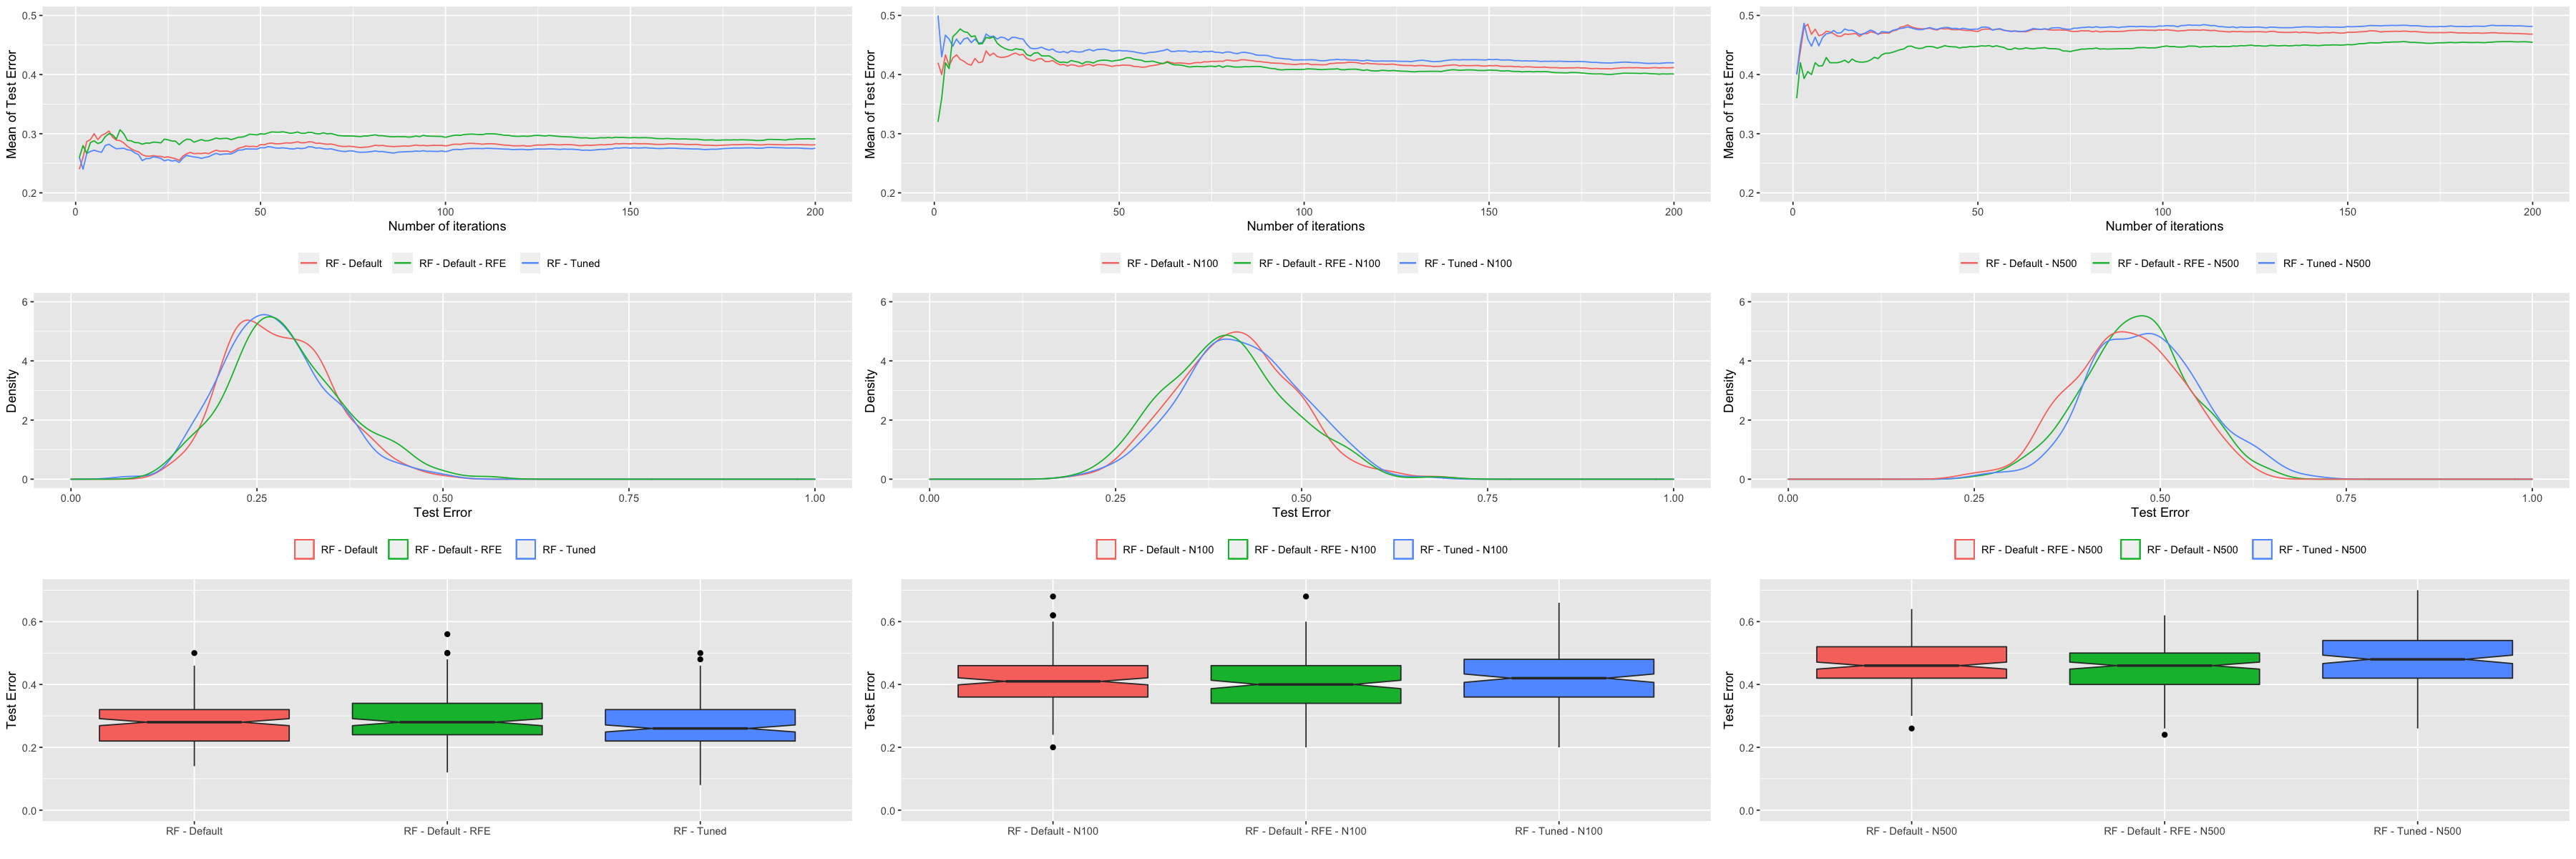

In [30]:
gg.average<-ggplot(data.frame(1:iter,average.rf.def.sim,average.rf.opt.sim,average.rf.rfe.def.sim),aes(x=1:iter))+geom_line(aes(y=average.rf.def.sim,color="RF - Default"))+geom_line(aes(y=average.rf.opt.sim,color="RF - Tuned"))+geom_line(aes(y=average.rf.rfe.def.sim,color="RF - Default - RFE"))+labs(x="Number of iterations",y="Mean of Test Error",color="Legend")+ylim(0.2,0.5)+theme(legend.position="bottom")+scale_color_discrete(name = "")
gg.average.N100<-ggplot(data.frame(1:iter,average.rf.def.N100.sim,average.rf.opt.N100.sim,average.rf.rfe.def.N100.sim),aes(x=1:iter))+geom_line(aes(y=average.rf.def.N100.sim,color="RF - Default - N100"))+geom_line(aes(y=average.rf.opt.N100.sim,color="RF - Tuned - N100"))+geom_line(aes(y=average.rf.rfe.def.N100.sim,color="RF - Default - RFE - N100"))+labs(x="Number of iterations",y="Mean of Test Error",color="Legend")+ylim(0.2,0.5)+theme(legend.position="bottom")+scale_color_discrete(name = "")
gg.average.N500<-ggplot(data.frame(1:iter,average.rf.def.N500.sim,average.rf.opt.N500.sim,average.rf.rfe.def.N500.sim),aes(x=1:iter))+geom_line(aes(y=average.rf.def.N500.sim,color="RF - Default - N500"))+geom_line(aes(y=average.rf.opt.N500.sim,color="RF - Tuned - N500"))+geom_line(aes(y=average.rf.rfe.def.N500.sim,color="RF - Default - RFE - N500"))+labs(x="Number of iterations",y="Mean of Test Error",color="Legend")+ylim(0.2,0.5)+theme(legend.position="bottom")+scale_color_discrete(name = "")

gg.density<-ggplot(data.frame(test.error.rf.def.sim,test.error.rf.opt.sim,test.error.rf.rfe.def.sim))+geom_density(aes(x=test.error.rf.def.sim,color="RF - Default"))+geom_density(aes(x=test.error.rf.opt.sim,color="RF - Tuned"))+geom_density(aes(x=test.error.rf.rfe.def.sim,color="RF - Default - RFE"))+
  scale_color_discrete(name = "")+labs(x="Test Error",y="Density",color="Legend")+xlim(0,1)+ylim(0,6)+theme(legend.position="bottom")
gg.density.N100<-ggplot(data.frame(test.error.rf.def.N100.sim,test.error.rf.opt.N100.sim,test.error.rf.rfe.def.N100.sim))+geom_density(aes(x=test.error.rf.def.N100.sim,color="RF - Default - N100"))+geom_density(aes(x=test.error.rf.opt.N100.sim,color="RF - Tuned - N100"))+geom_density(aes(x=test.error.rf.rfe.def.N100.sim,color="RF - Default - RFE - N100"))+
  scale_color_discrete(name = "")+labs(x="Test Error",y="Density",color="Legend")+xlim(0,1)+ylim(0,6)+theme(legend.position="bottom")
gg.density.N500<-ggplot(data.frame(test.error.rf.def.N500.sim,test.error.rf.opt.N500.sim,test.error.rf.rfe.def.N500.sim))+geom_density(aes(x=test.error.rf.def.N500.sim,color="RF - Default - N500"))+geom_density(aes(x=test.error.rf.opt.N500.sim,color="RF - Tuned - N500"))+geom_density(aes(x=test.error.rf.rfe.def.N500.sim,color="RF - Deafult - RFE - N500"))+
  scale_color_discrete(name = "")+labs(x="Test Error",y="Density",color="Legend")+xlim(0,1)+ylim(0,6)+theme(legend.position="bottom")

gg.boxplot.melt<-reshape2::melt(data.frame(test.error.rf.def.sim,test.error.rf.rfe.def.sim,test.error.rf.opt.sim),id.vars=NULL)
gg.boxplot.melt.N100<-reshape2::melt(data.frame(test.error.rf.def.N100.sim,test.error.rf.rfe.def.N100.sim,test.error.rf.opt.N100.sim),id.vars=NULL)
gg.boxplot.melt.N500<-reshape2::melt(data.frame(test.error.rf.def.N500.sim,test.error.rf.rfe.def.N500.sim,test.error.rf.opt.N500.sim),id.vars=NULL)
  
# Add variable parameter for axis label in dataset
levels(gg.boxplot.melt$variable) <- c("RF - Default","RF - Default - RFE","RF - Tuned")
levels(gg.boxplot.melt.N100$variable) <- c("RF - Default - N100","RF - Default - RFE - N100","RF - Tuned - N100")
levels(gg.boxplot.melt.N500$variable) <- c("RF - Default - N500","RF - Default - RFE - N500","RF - Tuned - N500")
  
gg.boxplot<-ggplot(gg.boxplot.melt,aes(x=variable,y=value,fill=variable))+geom_boxplot(outlier.colour="black", outlier.shape=16,outlier.size=2, notch=TRUE, show.legend=FALSE)+labs(x="",y="Test Error")+ylim(0,0.7)
gg.boxplot.N100<-ggplot(gg.boxplot.melt.N100,aes(x=variable,y=value,fill=variable))+geom_boxplot(outlier.colour="black", outlier.shape=16,outlier.size=2, notch=TRUE, show.legend=FALSE)+labs(x="",y="Test Error")+ylim(0,0.7)
gg.boxplot.N500<-ggplot(gg.boxplot.melt.N500,aes(x=variable,y=value,fill=variable))+geom_boxplot(outlier.colour="black", outlier.shape=16,outlier.size=2, notch=TRUE, show.legend=FALSE)+labs(x="",y="Test Error")+ylim(0,0.7)

gridExtra::grid.arrange(gg.average,gg.average.N100,gg.average.N500,gg.density,gg.density.N100,gg.density.N500,gg.boxplot,gg.boxplot.N100,gg.boxplot.N500, ncol=3,nrow=3)

As you can see in all three different types of plots, the test error for all three RFs increases with the number of irrelevant features. It is also interesting to see that the RF with prior RFE has the highest test error rate for the case without irrelevant features, while the *$m_{try}$* -tuned RF performs best on average. This picture changes as the amount of irrelevant features increases. For both cases (irrelevant features 100 and 500), the RF with prior RFE performs best on average compared to the other RFs.

###### Conlusion: Simulation 1
In the first simulation, it is clear that the "out-of-the-box" RF without tuning or prior RFE never performs best on average in all three cases, even when there are no irrelevant features. The higher the number of irrelevant variables, the better the RF with prior RFE. It is also interesting to note that the *$m_{try}$* -tuned RF performs best on average in the case with no irrelevant variables, but worst in all the other cases (irrelevant features 100 and 500). This is not consistent with the results of *Goldstein et al. (2011)*, as they said that *$m_{try}$* should be set higher when there are only a few relevant variables among many so that the algorithm can find the relevant variables.

Regarding the RFE it would be interesting to know if the algorithm can detect the irrelevant variables and how many it cancels at each iteration step. The following plot shows exactly that. The RFE with no irrelevant features is marked with the color *red*, the RFE with 100 irrelevant features with *green*, and the RFE with 500 irrelevant predictors with *blue*.

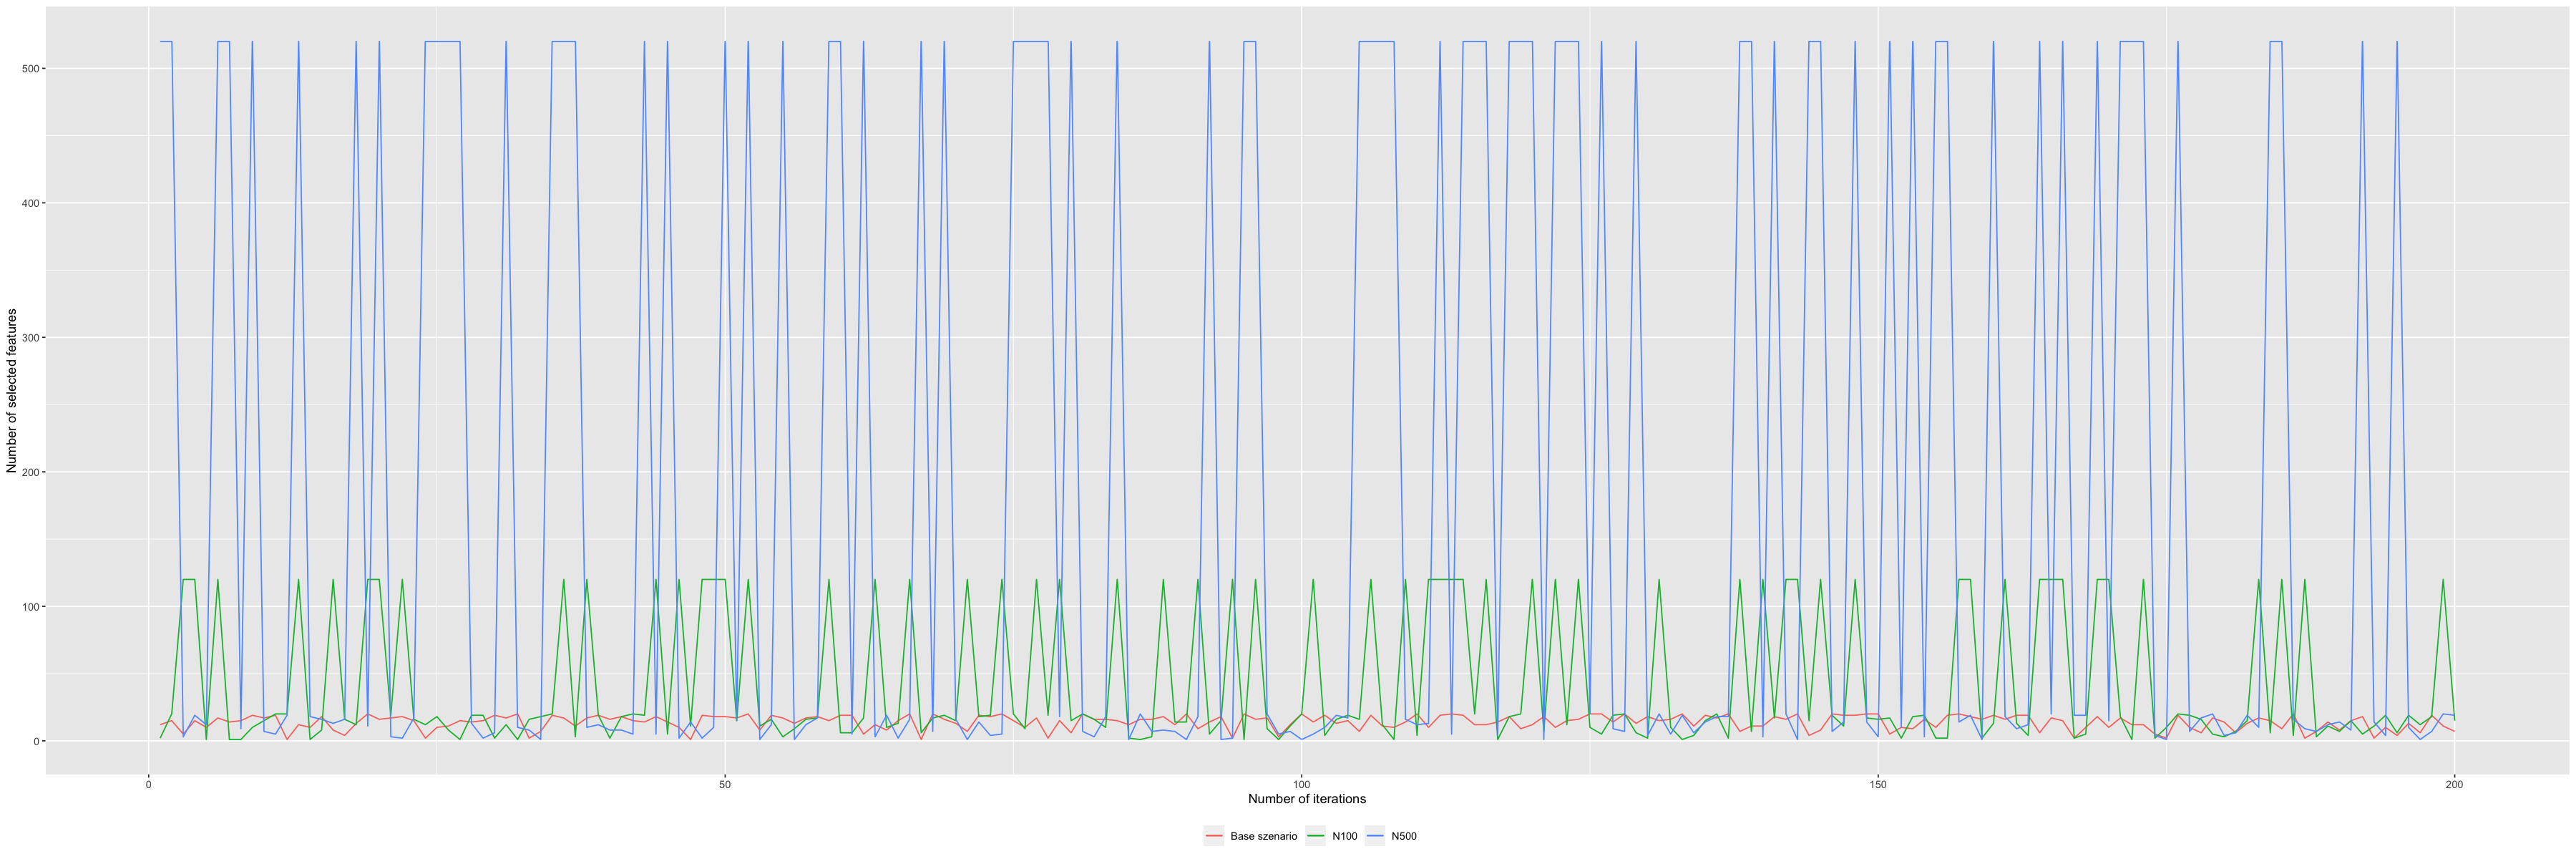

In [163]:
ggplot(data.frame(1:iter,length.X,length.X.N100,length.X.N500),aes(x=1:iter))+geom_line(aes(y=length.X,color="Base szenario"))+geom_line(aes(y=length.X.N100,color="N100"))+geom_line(aes(y=length.X.N500,color="N500"))+labs(x="Number of iterations",y="Number of selected features",color="Legend")+ylim(min(length.X,length.X.N100,length.X.N500),max(length.X,length.X.N100,length.X.N500))+theme(legend.position="bottom")+scale_color_discrete(name = "")

It is interesting to see that the RFE algorithm often selects the total set of features as relevant, especially in the cases where I added 100 and 500 irrelevant features, this behavior is not expected. It almost looks like a pattern in that the RFE algorithm fluctuates between a very small number of relevant features and the total set of features.

Overall, it can definitely be said that the best performance with a higher number of irrelevant features, the RF with prior RFE leads to the best test error compared to the RFs. However, it must also be said that the computational costs of the RFE algorithm are very high compared to the "out-of-the-box" RF or even to the $m_{try}$-tuned RF. Whether the performance gain is large enough compared to the computational cost depends on the situation and cannot be generalized.

*A word of caution regarding the $m_{try}$-tuning of the RF algorithm: When choosing the optimal value for the hyperparameter $m_{try}$, the loop always chooses the smallest value if the minimum of the test error is not unique. However, this could lead to a bias in the solution, as smaller values of $m_{try}$ lead to trees that perform worse on average (Probst et al., 2019). But, if there are many relevant predictors, $m_{try}$ should be chosen small because then not only will the strongest influential variables be chosen in the splits, but also less influential variables, which may yield a small but relevant performance gain (Probst et al., 2019). The same is transferred to the second simulation and the empirical application.*

*A word of caution about RFE: The RFE algorithm does not tell us how many features we can afford to removee. For a given x, RFE chooses which (d-x) features to remove from your set of d candidate features. But the value of x is not known. An incorrect value for x could increase the probability of overfitting or degrade performance.  For simplicity, I always removed as many features as the RFE algorithm indicated, i.e. (d-x) features. The same is applied to the second simulation and the empirical application.*

---
## B. Simulation 2
---
The DGP remains the same for the second simulation as described at the beginning of Chapter 4. The only difference is the variance-covariance matrix of the randomized $X$. I will assume, as in *Hapfelmeier et al. (2014)*, a general variance-covariance matrix with different covariance or correlation values, because $Var(X_{k})=1$, for $k=1,...,20$. In this case, $X$ is also drawn from a multivariate normal distribution:

- $X_{k}$ ~ $N(0,\Sigma)$, with $\Sigma = \begin{bmatrix}
            1.0 & r & r & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & \cdots & 0.0\\
            r & 1.0 & r & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & \cdots & 0.0\\
            r & r & 1.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & \cdots & 0.0\\
            0.0 & 0.0 & 0.0 & 1.0 & r & 0.0 & 0.0 & 0.0 & 0.0 & \cdots & 0.0\\
            0.0 & 0.0 & 0.0 & r & 1.0 & 0.0 & 0.0 & 0.0 & 0.0 & \cdots & 0.0\\
            0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.0 & r & r & r & \cdots & 0.0\\
            0.0 & 0.0 & 0.0 & 0.0 & 0.0 & r & 1.0 & r & r & \cdots & 0.0\\
            0.0 & 0.0 & 0.0 & 0.0 & 0.0 & r & r & 1.0 & r & \cdots & 0.0\\
            0.0 & 0.0 & 0.0 & 0.0 & 0.0 & r & r & r & 1.0 & \cdots & 0.0\\
            0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.0 & ... & 0.0\\
            \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & 0.0\\
            0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & \cdots & 1.0\\
        \end{bmatrix}$, with $k=1,...,20$

The correlation values vary for four different case, from no correlation to a strong positive correlation. Hence, the variable $r$ takes the values 0, 0.3, 0.6 and 0.9.

Given this simulation setup, I decided to use a wrapper method because the correlation between features now comes into play, and filtering methods may not select these features (*Kuhn, 2019*). A paper by *Gregorutti et al. (2017)* motivates modifying the DGP for a second simulation. They focused on variable selection algorithms based on RF analysis and evaluated recursive and non-recursive approaches. In the presence of correlated features, they showed that the RFE algorithm is more efficient than others, i.e., RFE reduces the impact of correlation on the importance measure. With the introduction of correlated features, I now want to see if the results of the first simulation are confirmed or if the "out-of-the-box" RF is best in comparison if there are no irrelevant but correlated features. However, based on the results of *Gregorutti et al. (2017)*, I would expect that the RF with prior RFE will perform better. An evaluation follows below.

The output of the functions used in this simulation and the test errors are stored in subdirectories of *Simulation/Data/Simulation_2*.

In [14]:
source("Simulation/container_sim2.R")

my_SIGMA <- lapply(1:4, function(x) {r <- c(0,.3,.6,.9)[x]; y <- diag(p);
  y[1:3, 1:3] <- r; y[4:5, 4:5] <- r; y[6:7, 6:7] <- r;
  y[8:11,8:11]<-r;diag(y)<-1;return(y)})

ptm.sim2<-proc.time()

for (i in 1:iter){
  set.seed (i)
  MyData.corr00<-DataGenerator(p, n, mu_vec, my_SIGMA[[1]], beta)
  MyData.corr03<-DataGenerator(p, n, mu_vec, my_SIGMA[[2]], beta)
  MyData.corr06<-DataGenerator(p, n, mu_vec, my_SIGMA[[3]], beta)
  MyData.corr09<-DataGenerator(p, n, mu_vec, my_SIGMA[[4]], beta)
  
  #Make train sample
  train.corr00 <- sample(1:nrow(MyData.corr00), n/2)
  train.corr03 <- sample(1:nrow(MyData.corr03), n/2)
  train.corr06 <- sample(1:nrow(MyData.corr06), n/2)
  train.corr09 <- sample(1:nrow(MyData.corr09), n/2)
  
  MyData.test.corr00 <- MyData.corr00[-train.corr00,]
  MyData.train.corr00 <- MyData.corr00[train.corr00,]
  MyData.test.corr03 <- MyData.corr03[-train.corr03,]
  MyData.train.corr03 <- MyData.corr03[train.corr03,]
  MyData.test.corr06 <- MyData.corr06[-train.corr06,]
  MyData.train.corr06 <- MyData.corr06[train.corr06,]
  MyData.test.corr09 <- MyData.corr09[-train.corr09,]
  MyData.train.corr09 <- MyData.corr09[train.corr09,]
  Y.test.corr00<- MyData.corr00$Y[-train.corr00]
  Y.test.corr03<- MyData.corr03$Y[-train.corr03]
  Y.test.corr06<- MyData.corr06$Y[-train.corr06]
  Y.test.corr09<- MyData.corr09$Y[-train.corr09]
  
  #Random Forest - default
  randomForest_default.corr00 <- randomForestDefault(data=MyData.corr00,subset=train.corr00)
  saveRDS(object = randomForest_default.corr00, file = paste0("Simulation/Data/Simulation_2/randomForest_default/RF_def_corr00_it", i, ".RDS"))
  
  #Random Forest - default - Test Error
  test.error.rf.def.corr00.sim[i]<- 1 - (table(randomForest_default.corr00, Y.test.corr00)[1,1] + table(randomForest_default.corr00, Y.test.corr00)[2,2] ) /(n/2)
  saveRDS(object = test.error.rf.def.corr00.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_default/Test_Errors/RF_def_corr00_it", i, ".RDS"))
  average.rf.def.corr00.sim[i]<-mean(test.error.rf.def.corr00.sim)
  saveRDS(object = average.rf.def.corr00.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_default/Test_Errors/Averages/RF_def_corr00_it", i, ".RDS"))                                                             

  #Random Forest - default - corr03
  randomForest_default.corr03 <- randomForestDefault(data=MyData.corr03,subset=train.corr03)
  saveRDS(object = randomForest_default.corr03, file = paste0("Simulation/Data/Simulation_2/randomForest_default/RF_def_corr03_it", i, ".RDS"))
  
  #Random Forest - default - corr03 - Test Error
  test.error.rf.def.corr03.sim[i] <- 1 - (table(randomForest_default.corr03, Y.test.corr03)[1,1] + table(randomForest_default.corr03, Y.test.corr03)[2,2] ) /(n/2)
  saveRDS(object = test.error.rf.def.corr03.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_default/Test_Errors/RF_def_corr03_it", i, ".RDS"))
  average.rf.def.corr03.sim[i]<-mean(test.error.rf.def.corr03.sim)
  saveRDS(object = average.rf.def.corr03.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_default/Test_Errors/Averages/RF_def_corr03_it", i, ".RDS"))                                                                                                                          
  
  #Random Forest - default - corr06
  randomForest_default.corr06 <- randomForestDefault(data=MyData.corr06,subset=train.corr06)
  saveRDS(object = randomForest_default.corr06, file = paste0("Simulation/Data/Simulation_2/randomForest_default/RF_def_corr06_it", i, ".RDS"))
                                                                
  #Random Forest - default - corr06 - Test Error
  test.error.rf.def.corr06.sim[i] <- 1 - (table(randomForest_default.corr06, Y.test.corr06)[1,1] + table(randomForest_default.corr06, Y.test.corr06)[2,2] ) /(n/2)
  saveRDS(object = test.error.rf.def.corr06.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_default/Test_Errors/RF_def_corr06_it", i, ".RDS"))
  average.rf.def.corr06.sim[i]<-mean(test.error.rf.def.corr06.sim)
  saveRDS(object = average.rf.def.corr06.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_default/Test_Errors/Averages/RF_def_corr06_it", i, ".RDS"))                                                                                                                          
                                                              
  #Random Forest - default - corr09
  randomForest_default.corr09 <- randomForestDefault(data=MyData.corr09,subset=train.corr09)
  saveRDS(object = randomForest_default.corr09, file = paste0("Simulation/Data/Simulation_2/randomForest_default/RF_def_corr09_it", i, ".RDS"))
   
  #Random Forest - default - corr09 - Test Error
  test.error.rf.def.corr09.sim[i] <- 1 - (table(randomForest_default.corr09, Y.test.corr09)[1,1] + table(randomForest_default.corr09, Y.test.corr09)[2,2] ) /(n/2)
  saveRDS(object = test.error.rf.def.corr09.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_default/Test_Errors/RF_def_corr09_it", i, ".RDS"))
  average.rf.def.corr09.sim[i]<-mean(test.error.rf.def.corr09.sim)
  saveRDS(object = average.rf.def.corr09.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_default/Test_Errors/Averages/RF_def_corr09_it", i, ".RDS"))                                                                                                                          
    
  #Random Forest - optimal
  randomForest_tuned.corr00 <- randomForestTuned(data=MyData.corr00,subset=train.corr00,Y.test=Y.test.corr00)
  saveRDS(object = randomForest_tuned.corr00, file = paste0("Simulation/Data/Simulation_2/randomForest_tuned/RF_tuned_corr00_it", i, ".RDS"))
  
  #Random Forest - optimal - Test Error
  test.error.rf.opt.corr00.sim[i] <- 1 - (table(randomForest_tuned.corr00, Y.test.corr00)[1,1] + table(randomForest_tuned.corr00, Y.test.corr00)[2,2] ) /(n/2)
  saveRDS(object = test.error.rf.opt.corr00.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_tuned/Test_Errors/RF_tuned_corr00_it", i, ".RDS"))
  average.rf.opt.corr00.sim[i]<-mean(test.error.rf.opt.corr00.sim)
  saveRDS(object = average.rf.opt.corr00.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_tuned/Test_Errors/Averages/RF_tuned_corr00_it", i, ".RDS"))
  
  #Random Forest - optimal - corr03
  randomForest_tuned.corr03 <- randomForestTuned(data=MyData.corr03,subset=train.corr03,Y.test=Y.test.corr03)
  saveRDS(object = randomForest_tuned.corr03, file = paste0("Simulation/Data/Simulation_2/randomForest_tuned/RF_tuned_corr03_it", i, ".RDS"))
  
  #Random Forest - optimal - Test Error
  test.error.rf.opt.corr03.sim[i] <- 1 - (table(randomForest_tuned.corr03, Y.test.corr03)[1,1] + table(randomForest_tuned.corr03, Y.test.corr03)[2,2] ) /(n/2)
  saveRDS(object = test.error.rf.opt.corr03.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_tuned/Test_Errors/RF_tuned_corr03_it", i, ".RDS"))
  average.rf.opt.corr03.sim[i]<-mean(test.error.rf.opt.corr03.sim)
  saveRDS(object = average.rf.opt.corr03.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_tuned/Test_Errors/Averages/RF_tuned_corr03_it", i, ".RDS"))
  
  #Random Forest - optimal - corr06
  randomForest_tuned.corr06 <- randomForestTuned(data=MyData.corr06,subset=train.corr06,Y.test=Y.test.corr06)
  saveRDS(object = randomForest_tuned.corr06, file = paste0("Simulation/Data/Simulation_2/randomForest_tuned/RF_tuned_corr06_it", i, ".RDS"))
  
  #Random Forest - optimal - Test Error
  test.error.rf.opt.corr06.sim[i] <- 1 - (table(randomForest_tuned.corr06, Y.test.corr06)[1,1] + table(randomForest_tuned.corr06, Y.test.corr06)[2,2] ) /(n/2)
  saveRDS(object = test.error.rf.opt.corr06.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_tuned/Test_Errors/RF_tuned_corr06_it", i, ".RDS"))
  average.rf.opt.corr06.sim[i]<-mean(test.error.rf.opt.corr06.sim)
  saveRDS(object = average.rf.opt.corr06.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_tuned/Test_Errors/Averages/RF_tuned_corr06_it", i, ".RDS"))
  
  #Random Forest - optimal - corr09
  randomForest_tuned.corr09 <- randomForestTuned(data=MyData.corr09,subset=train.corr09,Y.test=Y.test.corr09)
  saveRDS(object = randomForest_tuned.corr09, file = paste0("Simulation/Data/Simulation_2/randomForest_tuned/RF_tuned_corr09_it", i, ".RDS"))
  
  #Random Forest - optimal - Test Error
  test.error.rf.opt.corr09.sim[i] <- 1 - (table(randomForest_tuned.corr09, Y.test.corr09)[1,1] + table(randomForest_tuned.corr09, Y.test.corr09)[2,2] ) /(n/2)
  saveRDS(object = test.error.rf.opt.corr09.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_tuned/Test_Errors/RF_tuned_corr09_it", i, ".RDS"))
  average.rf.opt.corr09.sim[i]<-mean(test.error.rf.opt.corr09.sim)
  saveRDS(object = average.rf.opt.corr09.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_tuned/Test_Errors/Averages/RF_tuned_corr09_it", i, ".RDS"))
  
  #Recursive Feature Elimination
  RFE.corr00 <- RFEAlgo(data=MyData.corr00,data.train=MyData.train.corr00)
  saveRDS(object = RFE.corr00, file = paste0("Simulation/Data/Simulation_2/rfe/rfe_corr00_it", i, ".RDS"))
  
  length.X.corr00[i]<-NCOL(RFE.corr00[,-1])
    
  #Random Forest - default - RFE
  randomForest_rfe.corr00 <- randomForestDefault(data=RFE.corr00,subset=train.corr00)
  saveRDS(object = randomForest_rfe.corr00, file = paste0("Simulation/Data/Simulation_2/randomForest_rfe/RF_rfe_corr00_it", i, ".RDS"))
  
  #Random Forest - default - RFE - Test Error
  test.error.rf.rfe.def.corr00.sim[i] <- 1 - (table(randomForest_rfe.corr00, Y.test.corr00)[1,1] + table(randomForest_rfe.corr00, Y.test.corr00)[2,2] ) /(n/2)
  saveRDS(object = test.error.rf.rfe.def.corr00.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_rfe/Test_Errors/RF_rfe_corr00_it", i, ".RDS"))
  average.rf.rfe.def.corr00.sim[i]<-mean(test.error.rf.rfe.def.corr00.sim)
  saveRDS(object = average.rf.rfe.def.corr00.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_rfe/Test_Errors/Averages/RF_rfe_corr00_it", i, ".RDS"))
  
  #Recursive Feature Elimination - corr03
  RFE.corr03 <- RFEAlgo(data=MyData.corr03,data.train=MyData.train.corr03)
  saveRDS(object = RFE.corr03, file = paste0("Simulation/Data/Simulation_2/rfe/rfe_corr03_it", i, ".RDS"))
  
  length.X.corr03[i]<-NCOL(RFE.corr03[,-1])
  
  #Random Forest - default - RFE - corr03
  randomForest_rfe.corr03 <- randomForestDefault(data=RFE.corr03,subset=train.corr03)
  saveRDS(object = randomForest_rfe.corr03, file = paste0("Simulation/Data/Simulation_2/randomForest_rfe/RF_rfe_corr03_it", i, ".RDS"))
  
  #Random Forest - default - RFE - corr03 - Test Error
  test.error.rf.rfe.def.corr03.sim[i] <- 1 - (table(randomForest_rfe.corr03, Y.test.corr03)[1,1] + table(randomForest_rfe.corr03, Y.test.corr03)[2,2] ) /(n/2)
  saveRDS(object = test.error.rf.rfe.def.corr03.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_rfe/Test_Errors/RF_rfe_corr03_it", i, ".RDS"))
  average.rf.rfe.def.corr03.sim[i]<-mean(test.error.rf.rfe.def.corr03.sim)
  saveRDS(object = average.rf.rfe.def.corr03.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_rfe/Test_Errors/Averages/RF_rfe_corr03_it", i, ".RDS"))

  #Recursive Feature Elimination - corr06
  RFE.corr06 <- RFEAlgo(data=MyData.corr06,data.train=MyData.train.corr06)
  saveRDS(object = RFE.corr06, file = paste0("Simulation/Data/Simulation_2/rfe/rfe_corr06_it", i, ".RDS"))
  
  length.X.corr06[i]<-NCOL(RFE.corr06[,-1])
  
  #Random Forest - default - RFE - corr06
  randomForest_rfe.corr06 <- randomForestDefault(data=RFE.corr06,subset=train.corr06)
  saveRDS(object = randomForest_rfe.corr06, file = paste0("Simulation/Data/Simulation_2/randomForest_rfe/RF_rfe_corr06_it", i, ".RDS"))
  
  #Random Forest - default - RFE - corr06 - Test Error
  test.error.rf.rfe.def.corr06.sim[i] <- 1 - (table(randomForest_rfe.corr06, Y.test.corr06)[1,1] + table(randomForest_rfe.corr06, Y.test.corr06)[2,2] ) /(n/2)
  saveRDS(object = test.error.rf.rfe.def.corr06.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_rfe/Test_Errors/RF_rfe_corr06_it", i, ".RDS"))
  average.rf.rfe.def.corr06.sim[i]<-mean(test.error.rf.rfe.def.corr06.sim)
  saveRDS(object = average.rf.rfe.def.corr06.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_rfe/Test_Errors/Averages/RF_rfe_corr06_it", i, ".RDS"))

  #Recursive Feature Elimination - corr09
  RFE.corr09 <- RFEAlgo(data=MyData.corr09,data.train=MyData.train.corr09)
  saveRDS(object = RFE.corr09, file = paste0("Simulation/Data/Simulation_2/rfe/rfe_corr09_it", i, ".RDS"))
  
  length.X.corr09[i]<-NCOL(RFE.corr09[,-1])
  
  #Random Forest - default - RFE - corr09
  randomForest_rfe.corr09 <- randomForestDefault(data=RFE.corr09,subset=train.corr09)
  saveRDS(object = randomForest_rfe.corr09, file = paste0("Simulation/Data/Simulation_2/randomForest_rfe/RF_rfe_corr09_it", i, ".RDS"))
  
  #Random Forest - default - RFE - corr09 - Test Error
  test.error.rf.rfe.def.corr09.sim[i] <- 1 - (table(randomForest_rfe.corr09, Y.test.corr09)[1,1] + table(randomForest_rfe.corr09, Y.test.corr09)[2,2] ) /(n/2)
  saveRDS(object = test.error.rf.rfe.def.corr09.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_rfe/Test_Errors/RF_rfe_corr09_it", i, ".RDS"))
  average.rf.rfe.def.corr09.sim[i]<-mean(test.error.rf.rfe.def.corr09.sim)
  saveRDS(object = average.rf.rfe.def.corr09.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_rfe/Test_Errors/Averages/RF_rfe_corr09_it", i, ".RDS"))
}

stop.sim2<-proc.time()-ptm.sim2

saveRDS(object = test.error.rf.def.corr00.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_default/Test_Errors/RF_def_corr00_all.RDS"))
saveRDS(object = test.error.rf.def.corr03.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_default/Test_Errors/RF_def_corr03_all.RDS"))
saveRDS(object = test.error.rf.def.corr06.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_default/Test_Errors/RF_def_corr06_all.RDS"))
saveRDS(object = test.error.rf.def.corr09.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_default/Test_Errors/RF_def_corr09_all.RDS"))
saveRDS(object = test.error.rf.opt.corr00.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_tuned/Test_Errors/RF_tuned_corr00_all.RDS"))
saveRDS(object = test.error.rf.opt.corr03.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_tuned/Test_Errors/RF_tuned_corr03_all.RDS"))
saveRDS(object = test.error.rf.opt.corr06.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_tuned/Test_Errors/RF_tuned_corr06_all.RDS"))
saveRDS(object = test.error.rf.opt.corr09.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_tuned/Test_Errors/RF_tuned_corr09_all.RDS"))
saveRDS(object = test.error.rf.rfe.def.corr00.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_rfe/Test_Errors/RF_rfe_corr00_all.RDS"))
saveRDS(object = test.error.rf.rfe.def.corr03.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_rfe/Test_Errors/RF_rfe_corr03_all.RDS"))
saveRDS(object = test.error.rf.rfe.def.corr06.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_rfe/Test_Errors/RF_rfe_corr06_all.RDS"))
saveRDS(object = test.error.rf.rfe.def.corr09.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_rfe/Test_Errors/RF_rfe_corr09_all.RDS"))

saveRDS(object = average.rf.def.corr00.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_default/Test_Errors/Averages/RF_def_corr00_all.RDS"))
saveRDS(object = average.rf.def.corr03.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_default/Test_Errors/Averages/RF_def_corr03_all.RDS"))
saveRDS(object = average.rf.def.corr06.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_default/Test_Errors/Averages/RF_def_corr06_all.RDS"))
saveRDS(object = average.rf.def.corr09.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_default/Test_Errors/Averages/RF_def_corr09_all.RDS"))
saveRDS(object = average.rf.opt.corr00.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_tuned/Test_Errors/Averages/RF_tuned_corr00_all.RDS"))
saveRDS(object = average.rf.opt.corr03.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_tuned/Test_Errors/Averages/RF_tuned_corr03_all.RDS"))
saveRDS(object = average.rf.opt.corr06.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_tuned/Test_Errors/Averages/RF_tuned_corr06_all.RDS"))
saveRDS(object = average.rf.opt.corr09.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_tuned/Test_Errors/Averages/RF_tuned_corr09_all.RDS"))
saveRDS(object = average.rf.rfe.def.corr00.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_rfe/Test_Errors/Averages/RF_rfe_corr00_all.RDS"))
saveRDS(object = average.rf.rfe.def.corr03.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_rfe/Test_Errors/Averages/RF_rfe_corr03_all.RDS"))
saveRDS(object = average.rf.rfe.def.corr06.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_rfe/Test_Errors/Averages/RF_rfe_corr06_all.RDS"))
saveRDS(object = average.rf.rfe.def.corr09.sim, file = paste0("Simulation/Data/Simulation_2/randomForest_rfe/Test_Errors/Averages/RF_rfe_corr09_all.RDS"))

Twelve different graphs are shown below. The first column shows the test errors for the simulation without correlation, the second column shows the test errors for the simulation with correlation values of 0.3, the third column shows the test errors for the simulation with $r=0.6$, and the last column shows the test errors for the simulation with $r=0.9$. Here, the first row of plots shows the mean of the test errors over the number of iterations, the second row shows the density plots for the test errors, and the third row shows the boxplots for the test errors. The "out-of-the-box" RF is always marked with the color *red*, the RF with prior RFE with *green*, and the *$m_{try}$* -tuned RF with *blue*.

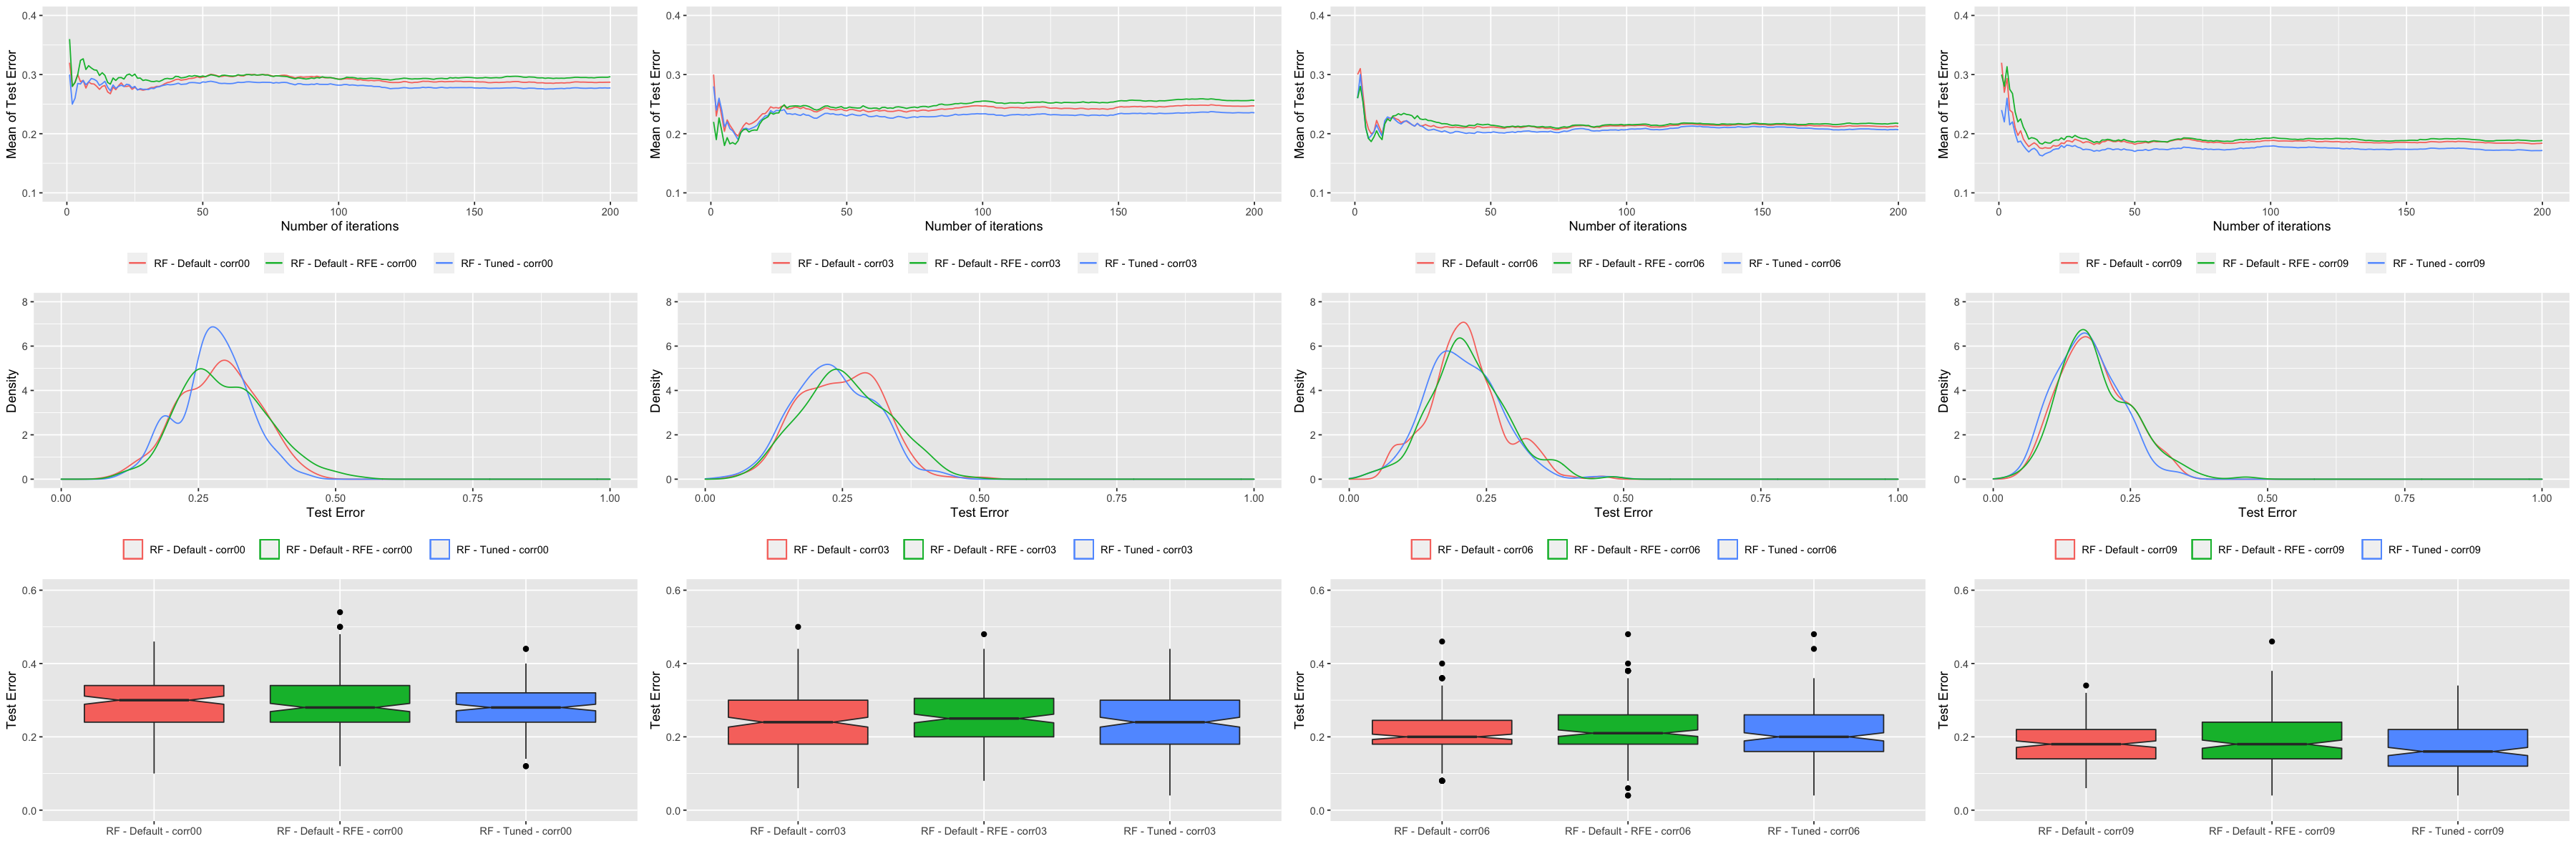

In [37]:
gg.average.corr00.sim2<-ggplot(data.frame(1:iter,average.rf.def.corr00.sim,average.rf.opt.corr00.sim,average.rf.rfe.def.corr00.sim),aes(x=1:iter))+geom_line(aes(y=average.rf.def.corr00.sim,color="RF - Default - corr00"))+geom_line(aes(y=average.rf.opt.corr00.sim,color="RF - Tuned - corr00"))+geom_line(aes(y=average.rf.rfe.def.corr00.sim,color="RF - Default - RFE - corr00"))+labs(x="Number of iterations",y="Mean of Test Error",color="Legend")+ylim(0.1,0.4)+theme(legend.position="bottom")+scale_color_discrete(name = "")
gg.average.corr03.sim2<-ggplot(data.frame(1:iter,average.rf.def.corr03.sim,average.rf.opt.corr03.sim,average.rf.rfe.def.corr03.sim),aes(x=1:iter))+geom_line(aes(y=average.rf.def.corr03.sim,color="RF - Default - corr03"))+geom_line(aes(y=average.rf.opt.corr03.sim,color="RF - Tuned - corr03"))+geom_line(aes(y=average.rf.rfe.def.corr03.sim,color="RF - Default - RFE - corr03"))+labs(x="Number of iterations",y="Mean of Test Error",color="Legend")+ylim(0.1,0.4)+theme(legend.position="bottom")+scale_color_discrete(name = "")
gg.average.corr06.sim2<-ggplot(data.frame(1:iter,average.rf.def.corr06.sim,average.rf.opt.corr06.sim,average.rf.rfe.def.corr06.sim),aes(x=1:iter))+geom_line(aes(y=average.rf.def.corr06.sim,color="RF - Default - corr06"))+geom_line(aes(y=average.rf.opt.corr06.sim,color="RF - Tuned - corr06"))+geom_line(aes(y=average.rf.rfe.def.corr06.sim,color="RF - Default - RFE - corr06"))+labs(x="Number of iterations",y="Mean of Test Error",color="Legend")+ylim(0.1,0.4)+theme(legend.position="bottom")+scale_color_discrete(name = "")
gg.average.corr09.sim2<-ggplot(data.frame(1:iter,average.rf.def.corr09.sim,average.rf.opt.corr09.sim,average.rf.rfe.def.corr09.sim),aes(x=1:iter))+geom_line(aes(y=average.rf.def.corr09.sim,color="RF - Default - corr09"))+geom_line(aes(y=average.rf.opt.corr09.sim,color="RF - Tuned - corr09"))+geom_line(aes(y=average.rf.rfe.def.corr09.sim,color="RF - Default - RFE - corr09"))+labs(x="Number of iterations",y="Mean of Test Error",color="Legend")+ylim(0.1,0.4)+theme(legend.position="bottom")+scale_color_discrete(name = "")

gg.density.corr00.sim2<-ggplot(data.frame(test.error.rf.def.corr00.sim,test.error.rf.opt.corr00.sim,test.error.rf.rfe.def.corr00.sim))+geom_density(aes(x=test.error.rf.def.corr00.sim,color="RF - Default - corr00"))+geom_density(aes(x=test.error.rf.opt.corr00.sim,color="RF - Tuned - corr00"))+geom_density(aes(x=test.error.rf.rfe.def.corr00.sim,color="RF - Default - RFE - corr00"))+
  scale_color_discrete(name = "")+labs(x="Test Error",y="Density",color="Legend")+xlim(0,1)+ylim(0,8)+theme(legend.position="bottom")
gg.density.corr03.sim2<-ggplot(data.frame(test.error.rf.def.corr03.sim,test.error.rf.opt.corr03.sim,test.error.rf.rfe.def.corr03.sim))+geom_density(aes(x=test.error.rf.def.corr03.sim,color="RF - Default - corr03"))+geom_density(aes(x=test.error.rf.opt.corr03.sim,color="RF - Tuned - corr03"))+geom_density(aes(x=test.error.rf.rfe.def.corr03.sim,color="RF - Default - RFE - corr03"))+
  scale_color_discrete(name = "")+labs(x="Test Error",y="Density",color="Legend")+xlim(0,1)+ylim(0,8)+theme(legend.position="bottom")
gg.density.corr06.sim2<-ggplot(data.frame(test.error.rf.def.corr06.sim,test.error.rf.opt.corr06.sim,test.error.rf.rfe.def.corr06.sim))+geom_density(aes(x=test.error.rf.def.corr06.sim,color="RF - Default - corr06"))+geom_density(aes(x=test.error.rf.opt.corr06.sim,color="RF - Tuned - corr06"))+geom_density(aes(x=test.error.rf.rfe.def.corr06.sim,color="RF - Default - RFE - corr06"))+
  scale_color_discrete(name = "")+labs(x="Test Error",y="Density",color="Legend")+xlim(0,1)+ylim(0,8)+theme(legend.position="bottom")
gg.density.corr09.sim2<-ggplot(data.frame(test.error.rf.def.corr09.sim,test.error.rf.opt.corr09.sim,test.error.rf.rfe.def.corr09.sim))+geom_density(aes(x=test.error.rf.def.corr09.sim,color="RF - Default - corr09"))+geom_density(aes(x=test.error.rf.opt.corr09.sim,color="RF - Tuned - corr09"))+geom_density(aes(x=test.error.rf.rfe.def.corr09.sim,color="RF - Default - RFE - corr09"))+
  scale_color_discrete(name = "")+labs(x="Test Error",y="Density",color="Legend")+xlim(0,1)+ylim(0,8)+theme(legend.position="bottom")

gg.boxplot.corr00.melt<-reshape2::melt(data.frame(test.error.rf.def.corr00.sim,test.error.rf.rfe.def.corr00.sim,test.error.rf.opt.corr00.sim),id.vars=NULL)
gg.boxplot.corr03.melt<-reshape2::melt(data.frame(test.error.rf.def.corr03.sim,test.error.rf.rfe.def.corr03.sim,test.error.rf.opt.corr03.sim),id.vars=NULL)
gg.boxplot.corr06.melt<-reshape2::melt(data.frame(test.error.rf.def.corr06.sim,test.error.rf.rfe.def.corr06.sim,test.error.rf.opt.corr06.sim),id.vars=NULL)
gg.boxplot.corr09.melt<-reshape2::melt(data.frame(test.error.rf.def.corr09.sim,test.error.rf.rfe.def.corr09.sim,test.error.rf.opt.corr09.sim),id.vars=NULL)
  
# Add variable parameter for axis label in dataset
levels(gg.boxplot.corr00.melt$variable) <- c("RF - Default - corr00","RF - Default - RFE - corr00","RF - Tuned - corr00")
levels(gg.boxplot.corr03.melt$variable) <- c("RF - Default - corr03","RF - Default - RFE - corr03","RF - Tuned - corr03")
levels(gg.boxplot.corr06.melt$variable) <- c("RF - Default - corr06","RF - Default - RFE - corr06","RF - Tuned - corr06")
levels(gg.boxplot.corr09.melt$variable) <- c("RF - Default - corr09","RF - Default - RFE - corr09","RF - Tuned - corr09")

gg.boxplot.corr00<-ggplot(gg.boxplot.corr00.melt,aes(x=variable,y=value,fill=variable))+geom_boxplot(outlier.colour="black", outlier.shape=16,outlier.size=2, notch=TRUE, show.legend=FALSE)+labs(x="",y="Test Error")+ylim(0.0,0.6)
gg.boxplot.corr03<-ggplot(gg.boxplot.corr03.melt,aes(x=variable,y=value,fill=variable))+geom_boxplot(outlier.colour="black", outlier.shape=16,outlier.size=2, notch=TRUE, show.legend=FALSE)+labs(x="",y="Test Error")+ylim(0.0,0.6)
gg.boxplot.corr06<-ggplot(gg.boxplot.corr06.melt,aes(x=variable,y=value,fill=variable))+geom_boxplot(outlier.colour="black", outlier.shape=16,outlier.size=2, notch=TRUE, show.legend=FALSE)+labs(x="",y="Test Error")+ylim(0.0,0.6)
gg.boxplot.corr09<-ggplot(gg.boxplot.corr09.melt,aes(x=variable,y=value,fill=variable))+geom_boxplot(outlier.colour="black", outlier.shape=16,outlier.size=2, notch=TRUE, show.legend=FALSE)+labs(x="",y="Test Error")+ylim(0.0,0.6)
                    
gridExtra::grid.arrange(gg.average.corr00.sim2,gg.average.corr03.sim2,gg.average.corr06.sim2,gg.average.corr09.sim2,gg.density.corr00.sim2,gg.density.corr03.sim2,gg.density.corr06.sim2,gg.density.corr09.sim2,gg.boxplot.corr00,gg.boxplot.corr03,gg.boxplot.corr06,gg.boxplot.corr09, ncol=4,nrow=3)

As can be seen in all three different types of plots, the test error for all three RFs decreases with a higher value of correlation. It is also interesting to see that the *$m_{try}$* -tuned RF has the lowest test error rate on average for all four cases. The same is true for the RF with prior RFE, which has the worst test error on average for all four cases.

###### Conlusion: Simulation 2
In the second simulation, the "out-of-the-box" RF without tuning or prior RFE performs best on average in all three cases. The higher the correlation, the better the *$m_{try}$* -tuned RF. The RF with prior RFE performs worst in all cases, which is in contrast to the results of *Gregorutti et al. (2017)*. However, this could be due to the fact that there are only a few features that are correlated with each other. A possible extension of the setup used could be one with correlations between all features. Another reason could be that there are no irrelevant features in the dataset and some relevant features are removed by the algorithm. Overall, however, it can be said that the correlation between the features has an influence on the performance of the methods, but only as a whole, since the ranking of the best performance between the methods always remains the same.

Regarding the RFE it would be interesting to know, as for the first simualtion, how many variables the RFE classifies as irrelevant. The following boxplot shows exactly that. The RFE with no correlation is marked with the color *red*, the RFE with $r=0.3$ with *green*, the RFE with $r=0.3$ with *blue*, and the RFE with $r=0.3$ with *purple*.

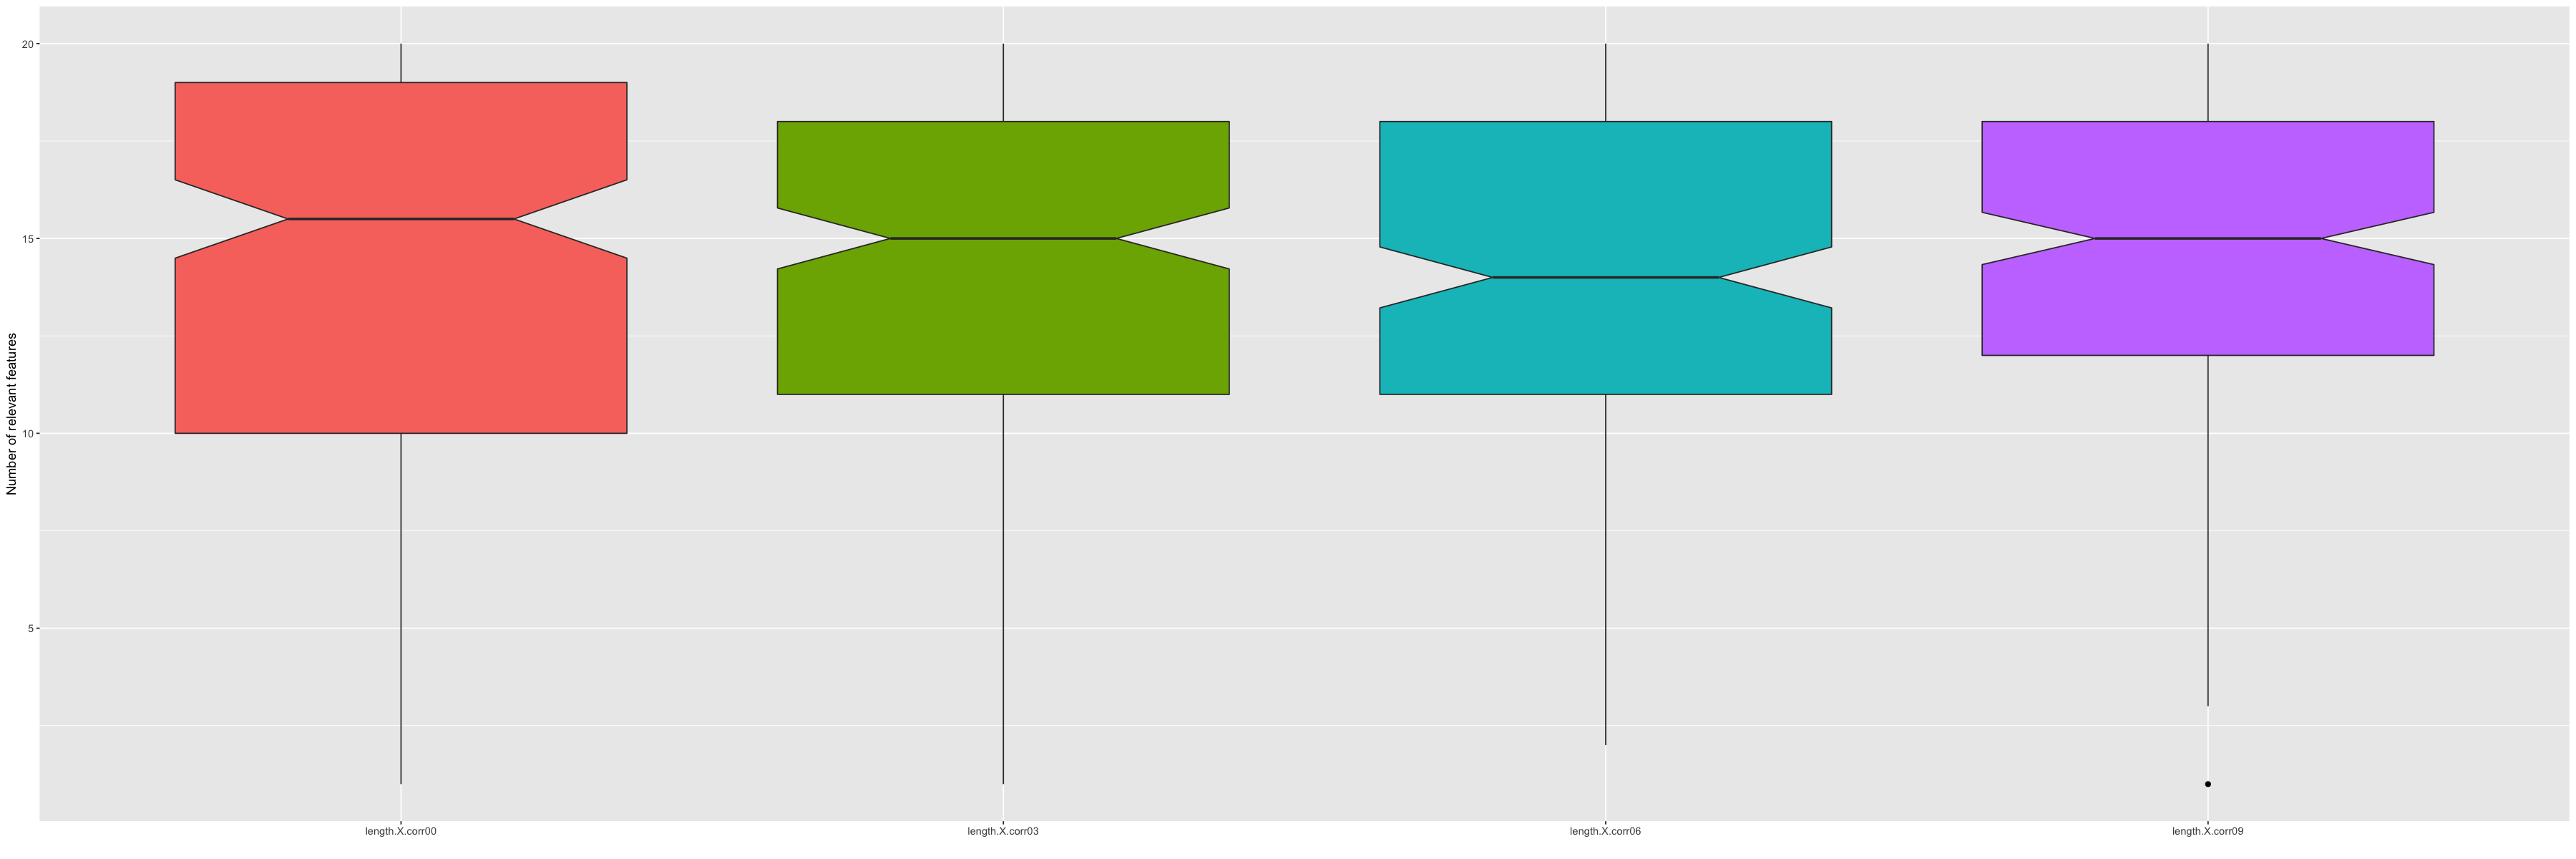

In [17]:
ggplot(reshape2::melt(data.frame(length.X.corr00,length.X.corr03,length.X.corr06,length.X.corr09),id.vars=NULL),aes(x=variable,y=value,fill=variable))+geom_boxplot(outlier.colour="black", outlier.shape=16,outlier.size=2, notch=TRUE, show.legend=FALSE)+labs(x="",y="Number of relevant features")

This plot does not look worrisome, as the number of relevant features selected by the RFE algorithm is relatively constant on average across all four cases, which was to be expected.

Overall, it can be said that the best performance was achieved by the *$m_{try}$* -tuned RF. It seems that for no irrelevant variables the gain of the RFE algorithm disappears and that one can save the high computational costs. The "out-of-the-box" RF is still not the best in this case, since the *$m_{try}$* -tuning leads to the lowest test error, whether with or without a correlation between features.

*The words of caution regarding the $m_{try}$-tuning of the RF algorithm and the RFE also apply for this simualtion (see Simulation 1).*

---
## 5. Empirical Application  <a name="application"></a>
---
For the empirical application, I want to use a dataset on German Credit Data from the UCI Repository of Machine Learning Databases.[<sup>4</sup>](#fn4) This dataset also finds also an application in a paper by *Chen (2018)*. It contains data on 20 attributes and one target collected in 1994 with 1000 observations. The dataset contains 7 numeric and 14 categorical variables:

| Attribute                                           | Type        |  | Attribute   | Type        |  | Target   | Type        |  
| :-------------------------------------------------- | :---------  |  | :---------- | :---------- |  | :----    -- | :---------  |  
| Status of existing checking account                 | qualitative |  | Present residence since   | numerical   |  | Credit risk | qualitative | 
| Duration in month                                   | numerical   |  | Property        | qualitative |       
| Credit history                                      | qualitative |  | Age in years    | numerical   |  
| Purpose                                             | qualitative || Other installment plans  | qualitative |
| Credit amount                                       | numerical   || Housing                | qualitative |
| Savings account/bonds                               | qualitative | | Number of existing credits at this bank | numerical   |
| Present employment since                            | qualitative | | Job                  | qualitative |
| Installment rate in percentage of disposable income | numerical   | | Number of people being liable to provide maintenance for | numerical   |
| Personal status and sex                             | qualitative | | Telephone                     | qualitative | 
| Other debtors/guarantors                            | qualitative | | Foreign worker                   | qualitative |

A description of the variables and the categories can be found on the homepage of the UCI Machine Learning Repository.[<sup>5</sup>](#fn5)

*Chen (2018)* aims to analyze German Credit Data using a series of tree-based models. Since banks have detailed data, it is important to develop models that distinguish between high-risk individuals and low-risk individuals. Since credit data is often unbalanced, i.e. the target class has an uneven distribution of observations, machine learning methods are particularly useful for analyzing it. In this dataset the target variable is highly imbalanced, as the number of high-risk observations (300 out of 1000) is significantly lower than the number of low-risk observations (700 out of 1000).

Compared to the simulation chapter where the predictor variables were numerical, it is also interesting to see if one can find similar behavior in terms of performance of the different RFs when most of the predictor variables are categorical. In addition, we can compare our methods with others, such as boosting, used in the paper.

In the following application, I will predict the individuals with "good" credit risk, since there is an imbalance between the predictions of individuals with "good" and "bad" credit risk. The prediction of good individuals was always more accurate than that of bad customers.[<sup>6</sup>](#fn6)

The output of the functions, used in this empirical applications are saved to subdirectories of *Application/Data*.

<span id="fn4"> <sup>[4]</sup>: See https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data). </span> <br>
<span id="fn5"> <sup>[5]</sup>: See https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc for downloading the dataset description. </span> <br>
<span id="fn6"> <sup>[6]</sup>: See the paper of *Chen (2018)* for more details on that. </span> <br>

In [172]:
set.seed(1)

german.credit.data <- read.table("Application/Data/german.data", quote="\"", comment.char="", stringsAsFactors=TRUE)
colnames(german.credit.data)<-c("checking.account","duration","credit.history","purpose","credit.amount",
                                "savings","employment","installment.rate","personal.status","other.debtors",
                                "residence","property","age","other.installment","housing","existing.credits",
                                "job","number.liable","telephone","foreign.worker","credit.risk")
german.credit.data$credit.risk<-as.factor(german.credit.data$credit.risk)

siz=c(300,700)
n_appl=round(0.7*siz)
german.credit.data$credit.risk <- factor(ifelse(german.credit.data$credit.risk ==1, "Yes", "No"))
german.credit.data=german.credit.data[order(german.credit.data$credit.risk),c(1:21)]
train_appl=sampling::strata(german.credit.data,stratanames = "credit.risk" ,size=n_appl,method="srswor")$ID_unit

credit.risk.test <- german.credit.data$credit.risk[-train_appl]

#Random Forest - default
randomForest_default.appl <- randomForestDefaultAppl(data=german.credit.data,subset=train_appl)
saveRDS(object = randomForest_default.appl, file = paste0("Application/Data/randomForest_default/RF_def_appl.RDS"))

#Random Forest - default - Test Error
test.error.randomForest_default.appl <- 1 - (table(randomForest_default.appl, credit.risk.test)[1,1] + table(randomForest_default.appl, credit.risk.test)[2,2] ) /siz[1]

#Random Forest - tuned
randomForest_tuned.appl<-randomForestTunedAppl(data=german.credit.data,subset=train_appl)
saveRDS(object = randomForest_tuned.appl, file = paste0("Application/Data/randomForest_tuned/RF_tuned_appl.RDS"))

#Random Forest - tuned - Test Error
test.error.randomForest_tuned.appl <- 1 - (table(randomForest_tuned.appl, credit.risk.test)[1,1] + table(randomForest_tuned.appl,credit.risk.test)[2,2] ) /siz[1]

#Recurive Feature Elimination 
german.credit.data.test <- german.credit.data[-train_appl,]
german.credit.data.train <- german.credit.data[train_appl,]
colnames(german.credit.data.train)[21]<-"credit.risk"

RFE.appl<-RFEAlgoAppl(data=german.credit.data,data.train = german.credit.data.train)
saveRDS(object = RFE.appl, file = paste0("Application/Data/rfe/rfe_appl.RDS"))

#Random Forest - default - RFE
randomForest_rfe.appl <- randomForestDefaultAppl(data=RFE.appl,subset=train_appl)
saveRDS(object = randomForest_rfe.appl, file = paste0("Application/Data/randomForest_rfe/RF_rfe_appl.RDS"))

#Random Forest - default - RFE - Test Error
test.error.randomforest_rfe.appl <- 1 - (table(randomForest_rfe.appl, credit.risk.test)[1,1] + table(randomForest_rfe.appl, credit.risk.test)[2,2] ) /siz[1]

Below is a barplot showing the test errors for the empirical application. The "out-of-the-box" RF is marked with *red*, the *$m_{try}$*-tuned RF with *green* and the RF with prior RFE with *blue*.

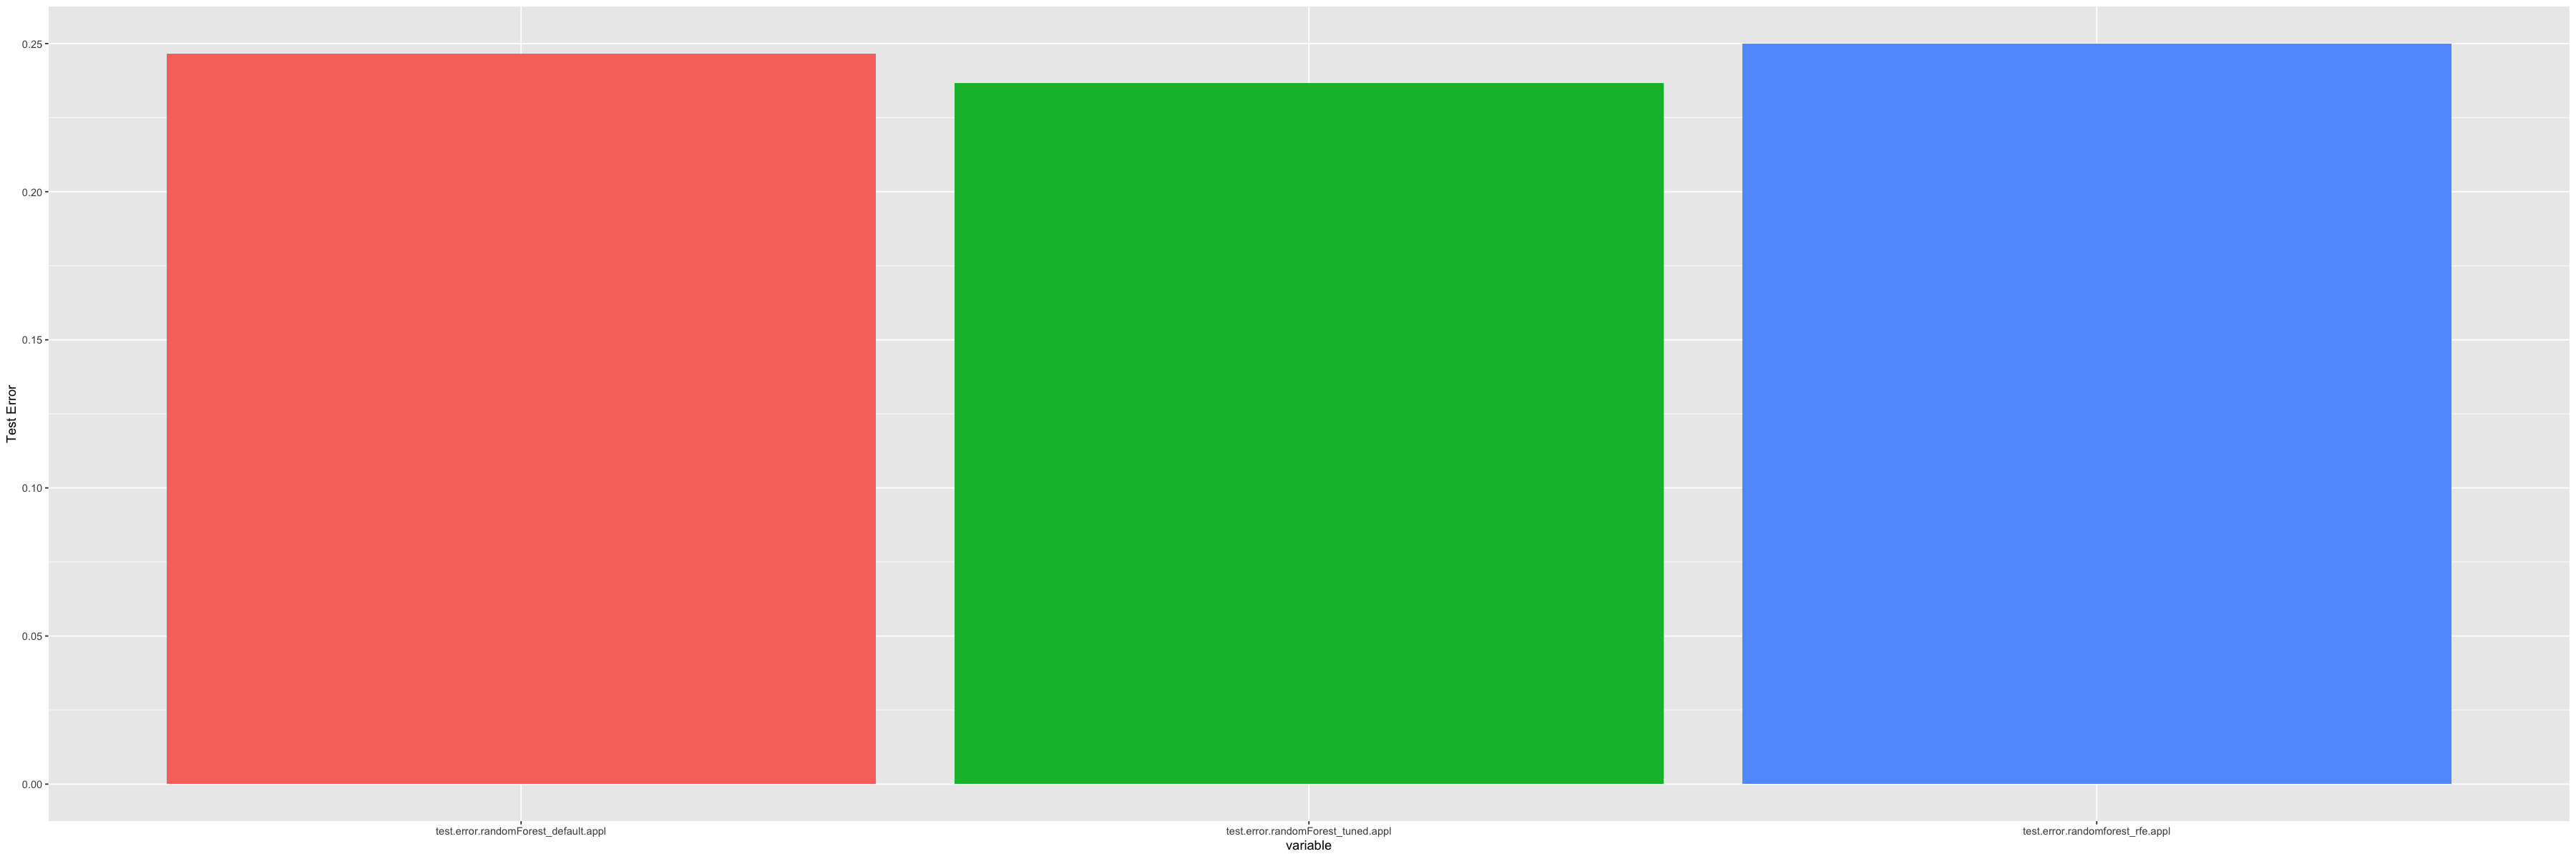

In [178]:
ggplot(reshape2::melt(data.frame(test.error.randomForest_default.appl,test.error.randomForest_tuned.appl,test.error.randomforest_rfe.appl),id.vars=NULL),aes(x=variable,y=value,fill=variable))+geom_bar(stat = "identity", show.legend=FALSE)+ylab("Test Error")

Regarding the Test Error, the $m_{try}$ -tuned Random Forest performs best, whereas the Random Forest with previous RFE is the worst.

###### Conclusion: Empirical Application
In general, the test error is relatively small in all three cases. The $m_{try}$ -tuned RF gives the best results in terms of test error. The same result was shown by the second simulation, which is the closest to the setup in this application, while the first simulation with a high number of irrelevant features does not apply to this setup. *Chen (2018)* provides similar results in his RF application, although he does not use test errors but the so-called *out-of-bag (OOB) error*.

*The words of caution regarding the $m_{try}$-tuning of the RF algorithm and the RFE also apply for this simualtion (see Simulation 1).*

---
## 6. Conclusion  <a name="conclusion"></a>
---
The goal of this project was to analyze whether the "out-of-the-box" RF is optimal. After an introduction to the theoretical prerequisites of the discussed methods, I conducted two different simulations and one empirical application. The results of the conducted simulation studies support the claim that the RF without tuning is not the optimal method in all cases. The "out-of-the-box" RF provides a good benchmark and can provide initial preliminary results, but depending on the situation, the *$m_{try}$* -tuned RF or the RF with prior RFE leads to better performance in terms of test errors. This shows that tuning hyperparameters, as discussed in *Probst et al. (2019)*, or feature selection leads to performance improvement. However, one must be aware and weigh how important a performance gain is relative to a highly increased computational cost, since the RFE algorithm, in particular, is very complex. A blanket recommendation cannot be made here. An application to a real-world data set connected to the prediction of credit risk shows that applied to real-world data, the performances of the applied methods come to similar conclusions. The hyperparameter-tuning also leads to an improvement in performance. In summary, the "out-of-the-box" RF does not deliver optimal performance in any of the cases discussed. However, it still provides a good benchmark and has a big advantage in terms of computational costs. If there is not a high amount of irrelevant variables, hyperparameter-tuning delivers a good performance. However, this picture changes when the number of irrelevant variables increases. Then one can hardly avoid a feature selection method if performance needs to be maximized.

When talking about possible extensions to this project, one could think about a variety of questions. One of them would be, how would performance improve if not just one hyperparameter, but all available parameters were adjusted? Would performance increase or would the computational cost be too high in comparison? Another interesting question arises when thinking about real data. Will the performance of the methods be biased if there are missing values in the data set? How does the RFE method cope with this problem? An interesting paper in this direction is *Hapfelmeier et al. (2014)*, which was also the basis for the DGP in both simulations. This would require a reformulation of the functions, but could reveal interesting information about the methods.

---
## 7. References <a name="references"></a>
---
- Ambroise, Christophe, and Geoffrey J. McLachlan. 2002. "Selection bias in gene extraction on the basis of microarray gene-expression data." Proceedings of the national academy of sciences 99, no. 10: 6562-6566. https://doi.org/10.1073/pnas.10210269.
- Bernard, Simon, Laurent Heutte, and Sébastien Adam. 2009. "Influence of hyperparameters on random forest accuracy." In International workshop on multiple classifier systems, pp. 171-180. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-642-02326-2_18.
- Boehmke, Brad, and Brandon Greenwell. 2019. "Hands-on machine learning with R." Chapman and Hall/CRC. https://bradleyboehmke.github.io/HOML/.
- Breiman, Leo. 2001. "Random forests." Machine Learning, 45 (1), 5–32. https://doi.org/10.1023/A:1010933404324.
- Breiman, Leo., Friedman, J.H., Olshen, R.A., & Stone, C.J. 1984. "Classification And Regression Trees." Routledge. https://doi.org/10.1201/9781315139470.
- Chen, Zhengye. 2018. "The application of tree-based model to unbalanced German credit data analysis." In MATEC Web of Conferences, vol. 232, p. 01005. EDP Sciences. https://10.1051/matecconf/201823201005.
- Goldstein, Benjamin A., Eric C. Polley, and Farren BS Briggs. 2011. "Random forests for genetic association studies." Statistical applications in genetics and molecular biology 10, no. 1. https://doi.org/10.2202/1544-6115.1691.
- Gregorutti, Baptiste, Bertrand Michel, and Philippe Saint-Pierre. 2017. "Correlation and variable importance in random forests." Statistics and Computing 27, no. 3: 659-678. https://doi.org/10.1007/s11222-016-9646-1.
- Guyon I.; Weston J.; Barnhill S.; Vapnik V. 2002. "Gene selection for cancer classification using support vector machines." Machine Learning. 46 (1–3): 389–422. https://doi.org/10.1023/A:1012487302797.
- Hapfelmeier, A., T. Hothorn, K. Ulm und C. Strobl (2014). "A New Variable Importance Measure for Random Forests with Missing Data." Statistics and Computing 24, 21–34. https://doi.org/10.1007/s11222-012-9349-1.
- Ho, Tin Kam. 1995. "Random Decision Forests." In Proceedings of 3rd International Conference on Document Analysis and Recognition, 1:278–82 vol.1. https://doi.org/10.1109/ICDAR.1995.598994.
- James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. 2021. "An Introduction to Statistical Learning: With Applications in R." Second Edition. New York: Springer.
- John, George H., Ron Kohavi, and Karl Pfleger. 1994. "Irrelevant features and the subset selection problem." In Machine learning proceedings, pp. 121-129. Morgan Kaufmann. https://doi.org/10.1016/B978-1-55860-335-6.50023-4.
- Kuhn, Max. 2019. "The caret Package." https://topepo.github.io/caret/index.html.
- Kuzilek, Jakub, Vaclav Kremen, Filip Soucek, and Lenka Lhotska. 2014. "Independent component analysis and decision trees for ECG holter recording de-noising." PLoS One 9.6: e98450. https://doi.org/10.1371/journal.pone.0098450.
- Probst, Philipp, Marvin N. Wright, and Anne-Laure Boulesteix. 2019. “Hyperparameters and Tuning Strategies for Random Forest.” Wiley Interdisciplinary Reviews: Data Mining and Knowledge Discovery 9 (3): e1301. https://doi.org/10.1002/widm.1301.
- Rogers, Jeremy, and Steve Gunn. 2005. "Identifying feature relevance using a random forest." In International Statistical and Optimization Perspectives Workshop" Subspace, Latent Structure and Feature Selection", pp. 173-184. Springer, Berlin, Heidelberg. https://doi.org/10.1007/11752790_12
- Saeys, Yvan, Inaki Inza, and Pedro Larranaga. 2017. "A review of feature selection techniques in bioinformatics." bioinformatics 23, no. 19: 2507-2517. https://doi.org/10.1093/bioinformatics/btm344.
- Strobl, Carolin, Anne-Laure Boulesteix, Achim Zeileis, and Torsten Hothorn. 2007. "Bias in Random Forest Variable Importance Measures: Illustrations, Sources and a Solution." BMC Bioinformatics 8 (1). BioMed Central: 25. https://doi.org/10.1186/1471-2105-8-25.
- Verikas, A., Gelzinis, A., & Bacauskiene, M. 2011. "Mining data with random forests: A survey and results of new tests." Pattern recognition, 44(2), 330-349. https://doi.org/10.1016/j.patcog.2010.08.011.